In [2556]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import warnings
get_ipython().run_line_magic('matplotlib', 'inline')
rcParams['figure.figsize']=5,4
sns.set_style('whitegrid')
warnings.filterwarnings(action="ignore")





import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

plt.style.use('seaborn-white')


import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go




About this dataset
Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-3)

cp : Chest Pain type chest pain type

Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic
trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach : maximum heart rate achieved

target : 0= less chance of heart attack 1= more chance of heart attack

n

Import the Dataset

In [2557]:
dfOG = pd.read_csv('heart.csv')




In [2558]:
dfOG.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [2559]:
for column in dfOG:
    print(column,": ")
    print(dfOG[column].unique(),"\n")

age : 
[63 37 41 56 57 44 52 54 48 49 64 58 50 66 43 69 59 42 61 40 71 51 65 53
 46 45 39 47 62 34 35 29 55 60 67 68 74 76 70 38 77] 

sex : 
[1 0] 

cp : 
[3 2 1 0] 

trtbps : 
[145 130 120 140 172 150 110 135 160 105 125 142 155 104 138 128 108 134
 122 115 118 100 124  94 112 102 152 101 132 148 178 129 180 136 126 106
 156 170 146 117 200 165 174 192 144 123 154 114 164] 

chol : 
[233 250 204 236 354 192 294 263 199 168 239 275 266 211 283 219 340 226
 247 234 243 302 212 175 417 197 198 177 273 213 304 232 269 360 308 245
 208 264 321 325 235 257 216 256 231 141 252 201 222 260 182 303 265 309
 186 203 183 220 209 258 227 261 221 205 240 318 298 564 277 214 248 255
 207 223 288 160 394 315 246 244 270 195 196 254 126 313 262 215 193 271
 268 267 210 295 306 178 242 180 228 149 278 253 342 157 286 229 284 224
 206 167 230 335 276 353 225 330 290 172 305 188 282 185 326 274 164 307
 249 341 407 217 174 281 289 322 299 300 293 184 409 259 200 327 237 218
 319 166 311 169 187 176 241

In [2560]:
dict = {}
for i in list(dfOG.columns):
    dict[i] = dfOG[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


Importance

[0.06787924 0.05654299 0.12466748 0.06183106 0.06221247 0.01982405
 0.03332993 0.08586443 0.1034531  0.08565675 0.0722852  0.12810474
 0.09834857]


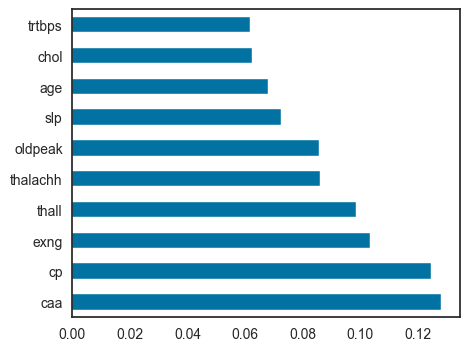

In [2561]:
#Show the importance of the features in the dataset
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(dfOG.drop('output',axis=1),dfOG['output'])
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=dfOG.drop('output',axis=1).columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()



Number of Men: 207 Number of Women: 96
The difference between the two is 111
Therefore, we need to either accept the biasd in the data or remedy it.
Based on the numbers, there is a  53.62318840579711 % difference.
This is a significant difference and should be remedied.


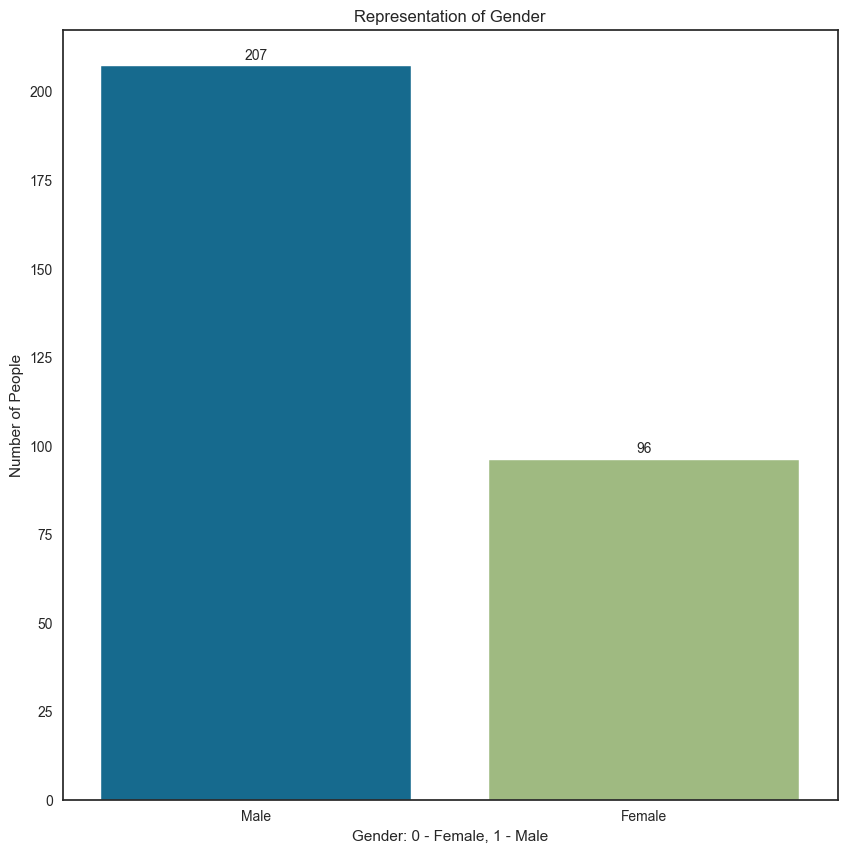

In [2562]:
x=(dfOG.sex.value_counts())
print(f'Number of Men: {x[1]} Number of Women: {x[0]}')

#Get the Difference between the two
diff = x[1] - x[0]
print(f'The difference between the two is {diff}')
print("Therefore, we need to either accept the biasd in the data or remedy it.")
#Get the difference as a percentage
percent = (diff/x[1])*100

print("Based on the numbers, there is a ",percent,"% difference.")
print("This is a significant difference and should be remedied.")



#Convert the values to strings
dfOG.sex = dfOG.sex.astype(str)
#Replace the values
dfOG.sex = dfOG.sex.replace('0', 'Female')
dfOG.sex = dfOG.sex.replace('1', 'Male')

p = sns.countplot(data=dfOG, x='sex')
plt.title("Representation of Gender")
plt.gcf().set_size_inches(10, 10)
#Label the Bars
for bar in p.patches:
    p.annotate(format(bar.get_height(), '.0f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
               size=10, xytext=(0, 8),
               textcoords='offset points')

#Bar Labels
plt.ylabel('Number of People')
plt.xlabel('Gender: 0 - Female, 1 - Male')

plt.show()

In [2563]:
dfOG.sex = dfOG.sex.replace('Female', '0')
dfOG.sex = dfOG.sex.replace('Male', '1')

In [2564]:
#Get the difference between the two
diff = x[1] - x[0]

#Add more rows with 'sex' as 0
augmentedData = dfOG.sample(diff,replace=True,random_state=529)

new_rows = augmentedData.copy()
new_rows['sex'] = '0'

dfOG = dfOG.append(new_rows)

#Check to see if the difference is now 0
#Take an updated count
x=(dfOG.sex.value_counts())
print(x)
print("Verified that the difference is now 0.")


1    207
0    207
Name: sex, dtype: int64
Verified that the difference is now 0.


In [2565]:
#Find and replace any Nan values with the mean

#Find any Nan values
dfOG.isnull().sum()





age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

0    198
2    115
1     70
3     31
Name: cp, dtype: int64


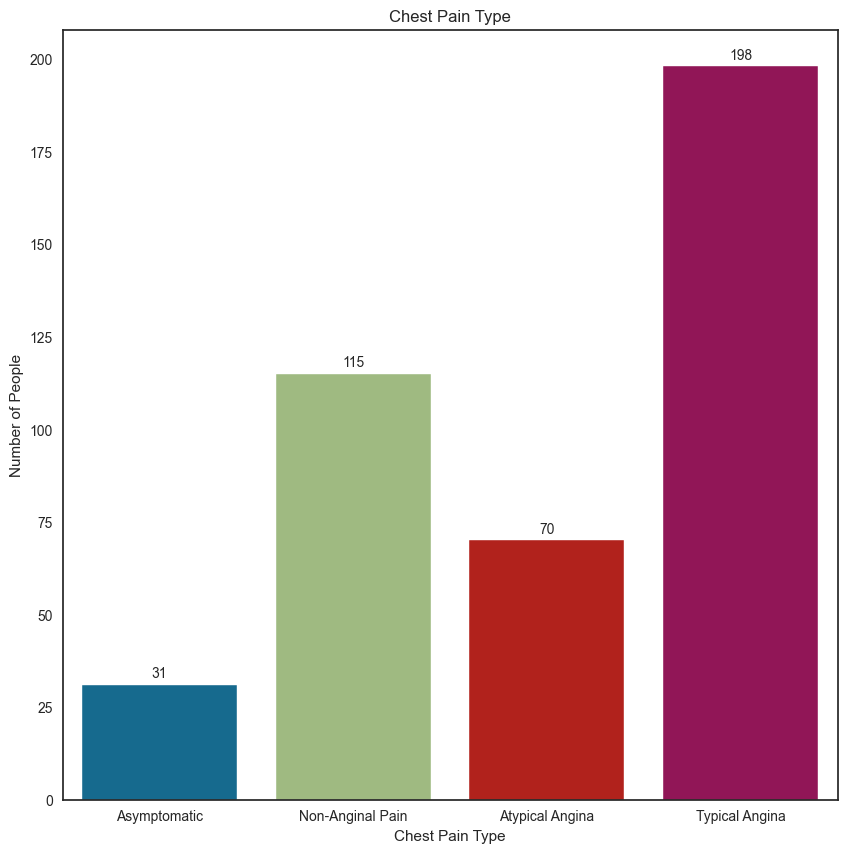

In [2566]:
x=(dfOG.cp.value_counts())
print(x)
#Convert the values to strings
dfOG.cp = dfOG.cp.astype(str)
#Replace the values
dfOG.cp = dfOG.cp.replace('0', 'Typical Angina')
dfOG.cp = dfOG.cp.replace('1', 'Atypical Angina')
dfOG.cp = dfOG.cp.replace('2', 'Non-Anginal Pain')
dfOG.cp = dfOG.cp.replace('3', 'Asymptomatic')

p = sns.countplot(data=dfOG, x='cp')
#Expand the plot
plt.gcf().set_size_inches(10, 10)
for bar in p.patches:
    p.annotate(format(bar.get_height(), '.0f'),
               (bar.get_x() + bar.get_width() / 2,
                bar.get_height()), ha='center', va='center',
               size=10, xytext=(0, 8),
               textcoords='offset points')

plt.ylabel('Number of People')
plt.xlabel('Chest Pain Type')

#Bar Labels
plt.title('Chest Pain Type')


plt.show()

In [2567]:
dfOG.cp = dfOG.cp.replace('Typical Angina', '0')
dfOG.cp = dfOG.cp.replace('Atypical Angina', '1')
dfOG.cp = dfOG.cp.replace('Non-Anginal Pain', '2')
dfOG.cp = dfOG.cp.replace('Asymptomatic', '3')

0    358
1     56
Name: fbs, dtype: int64


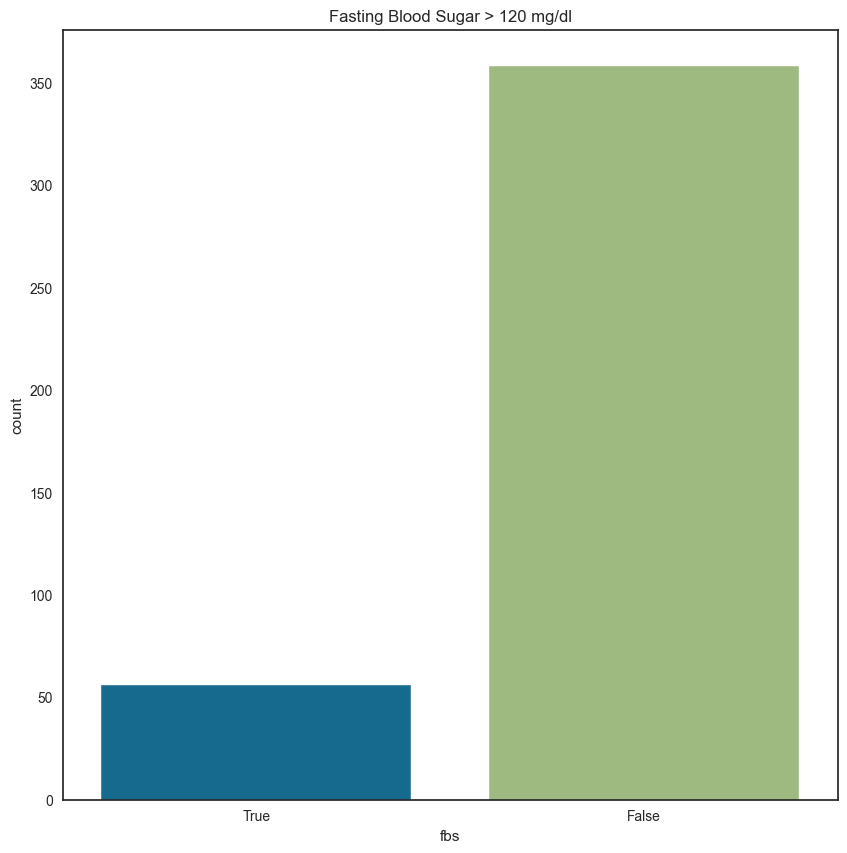

In [2568]:
x=(dfOG.fbs.value_counts())

#Convert the values to strings
dfOG.fbs = dfOG.fbs.astype(str)
#Replace the values
dfOG.fbs = dfOG.fbs.replace('0', 'False')
dfOG.fbs = dfOG.fbs.replace('1', 'True')

#Make the plot bigger
plt.gcf().set_size_inches(10, 10)

print(x)
#Add a title
plt.title('Fasting Blood Sugar > 120 mg/dl')
p = sns.countplot(data=dfOG, x="fbs")
plt.show()

In [2569]:
dfOG.fbs = dfOG.fbs.replace('False', '0')
dfOG.fbs = dfOG.fbs.replace('True', '1')

1    210
0    198
2      6
Name: restecg, dtype: int64


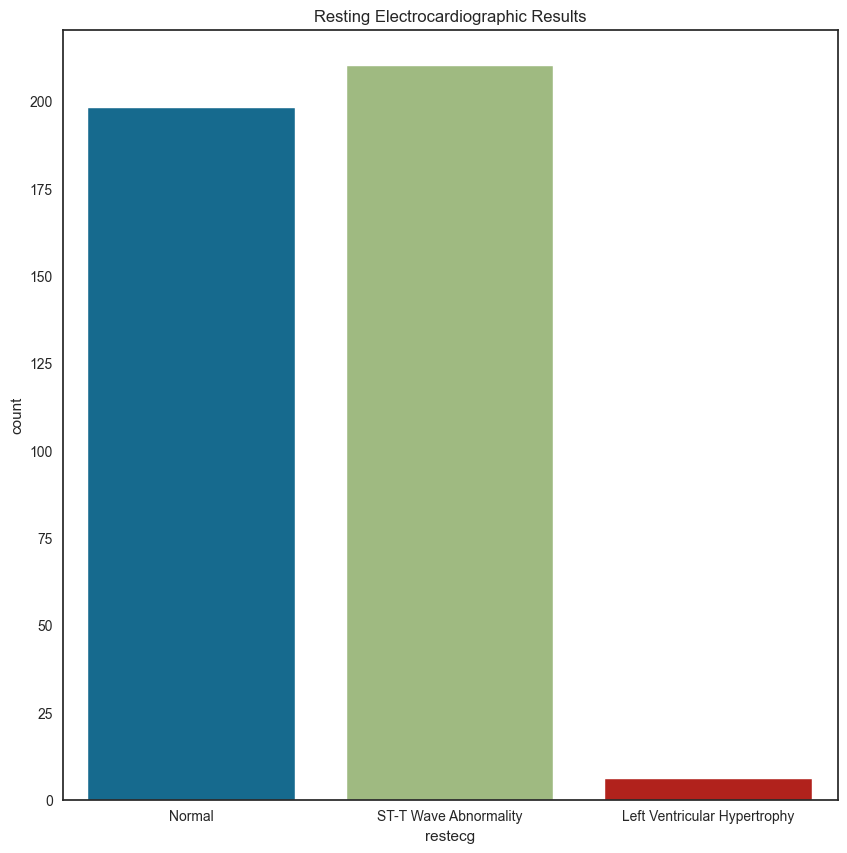

In [2570]:
x=(dfOG.restecg.value_counts())
print(x)
#Convert the values to strings
dfOG.restecg = dfOG.restecg.astype(str)
#Replace the values
dfOG.restecg = dfOG.restecg.replace('0', 'Normal')
dfOG.restecg = dfOG.restecg.replace('1', 'ST-T Wave Abnormality')
dfOG.restecg = dfOG.restecg.replace('2', 'Left Ventricular Hypertrophy')

#Make the plot bigger
plt.gcf().set_size_inches(10, 10)

#Add a title
plt.title('Resting Electrocardiographic Results')

p = sns.countplot(data=dfOG, x="restecg")
plt.show()

In [2571]:
dfOG.restecg = dfOG.restecg.replace('Normal', '0')
dfOG.restecg = dfOG.restecg.replace('ST-T Wave Abnormality', '1')
dfOG.restecg = dfOG.restecg.replace('Left Ventricular Hypertrophy', '2')

0    283
1    131
Name: exng, dtype: int64


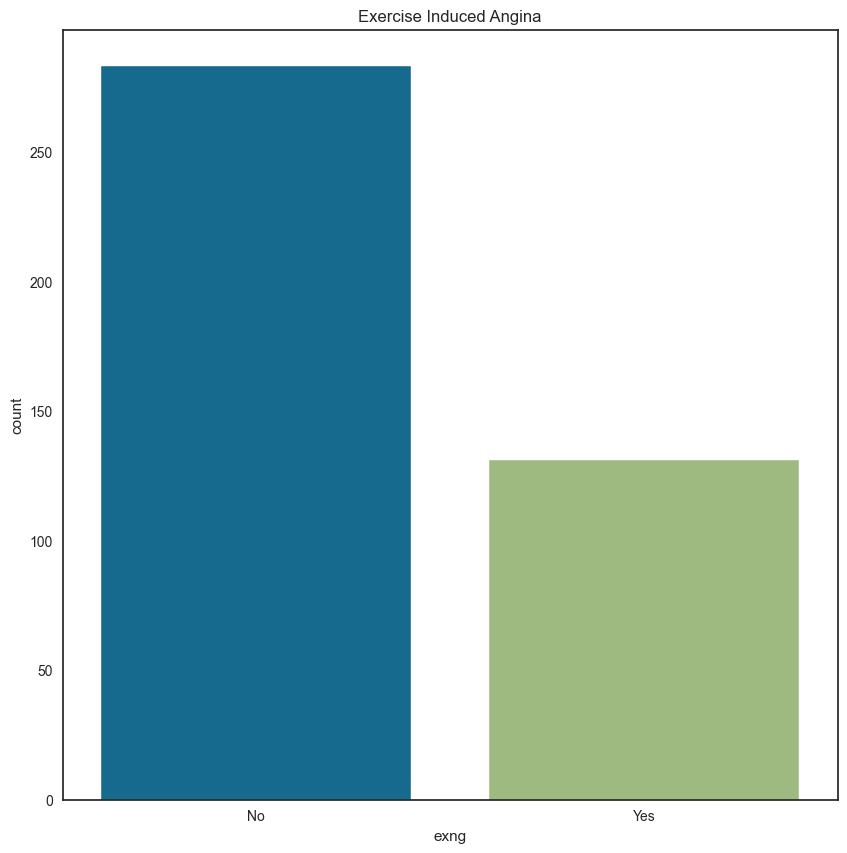

In [2572]:
x=(dfOG.exng.value_counts())
print(x)
#Convert the values to strings
dfOG.exng = dfOG.exng.astype(str)
#Replace the values
dfOG.exng = dfOG.exng.replace('0', 'No')
dfOG.exng = dfOG.exng.replace('1', 'Yes')

#Make the plot bigger
plt.gcf().set_size_inches(10, 10)

#Add a title
plt.title('Exercise Induced Angina')

p = sns.countplot(data=dfOG, x="exng")
plt.show()

In [2573]:
dfOG.exng = dfOG.exng.replace('No', '0')
dfOG.exng = dfOG.exng.replace('Yes', '1')

2    226
3    155
1     30
0      3
Name: thall, dtype: int64


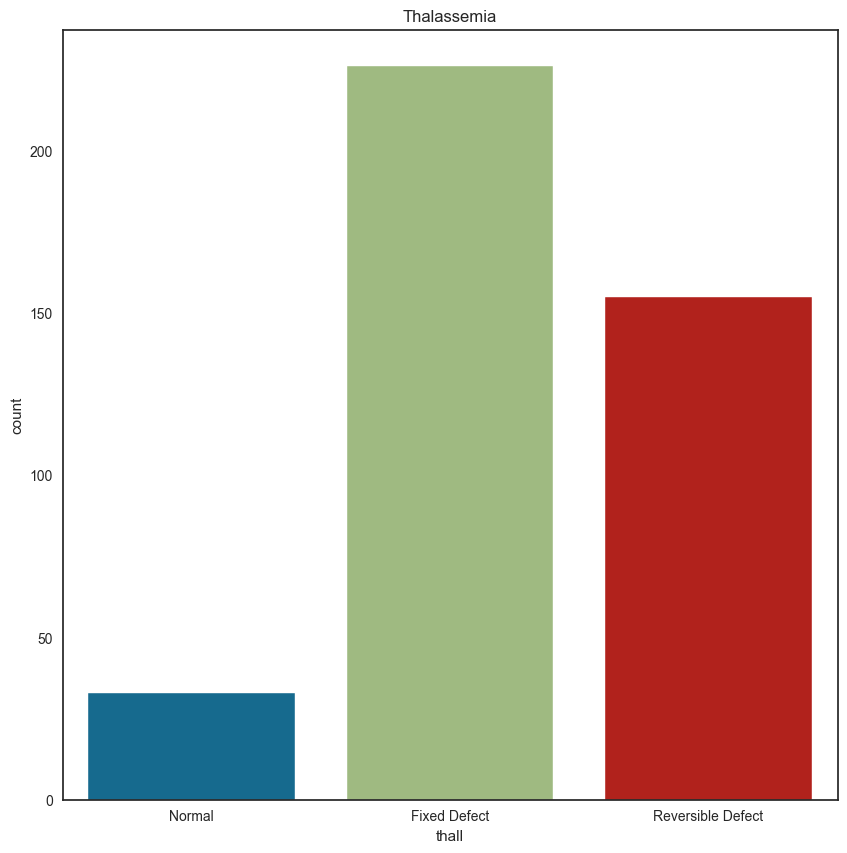

In [2574]:
x=(dfOG.thall.value_counts())
print(x)
#Convert the values to strings
dfOG.thall = dfOG.thall.astype(str)
#Replace the values


dfOG.thall = dfOG.thall.replace('0', 'Normal')
dfOG.thall = dfOG.thall.replace('1', 'Normal')
dfOG.thall = dfOG.thall.replace('2', 'Fixed Defect')
dfOG.thall = dfOG.thall.replace('3', 'Reversible Defect')

#Make the plot bigger
plt.gcf().set_size_inches(10, 10)

#Add a title
plt.title('Thalassemia')

p = sns.countplot(data=dfOG, x="thall")
plt.show()

In [2575]:
dfOG.thall = dfOG.thall.replace('Normal', '0')
dfOG.thall = dfOG.thall.replace('Normal', '1')
dfOG.thall = dfOG.thall.replace('Fixed Defect', '2')
dfOG.thall = dfOG.thall.replace('Reversible Defect', '3')

<Figure size 1000x1000 with 0 Axes>

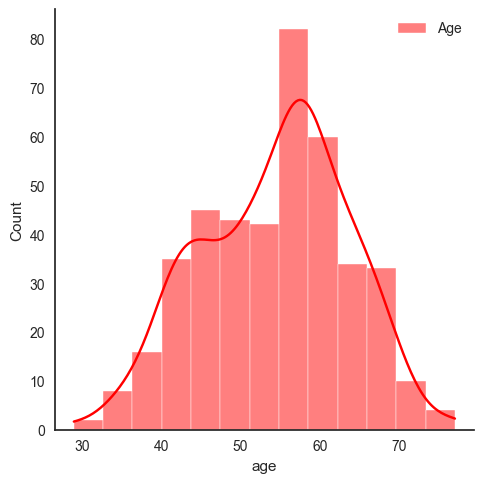

In [2576]:
plt.figure(figsize=(10,10))
sns.displot(dfOG.age, color="red", label="Age", kde= True)
plt.legend()

<Figure size 2000x2000 with 0 Axes>

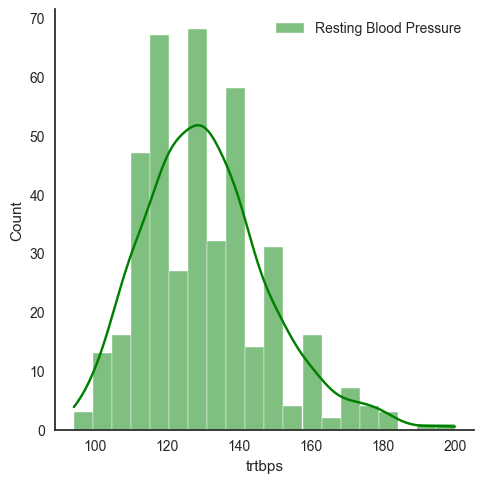

In [2577]:
plt.figure(figsize=(20,20))
sns.displot(dfOG.trtbps , color="green", label="Resting Blood Pressure", kde= True)
plt.legend()

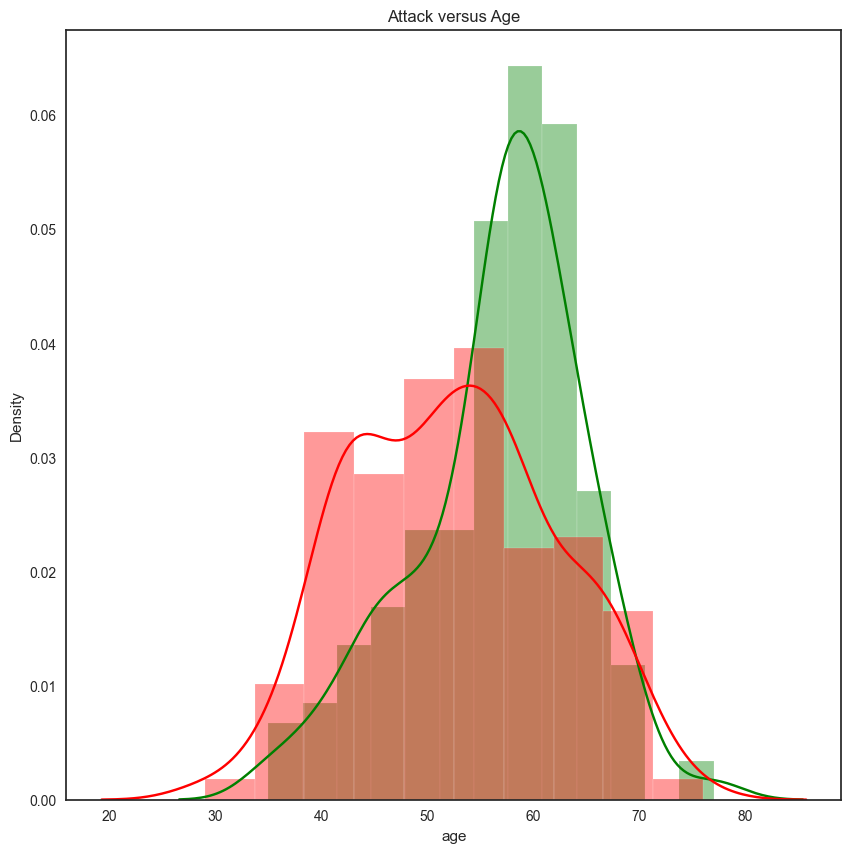

In [2578]:
plt.figure(figsize=(10,10))
sns.distplot(dfOG[dfOG['output'] == 0]["age"], color='green',kde=True,)
sns.distplot(dfOG[dfOG['output'] == 1]["age"], color='red',kde=True)
plt.title('Attack versus Age')
plt.show()


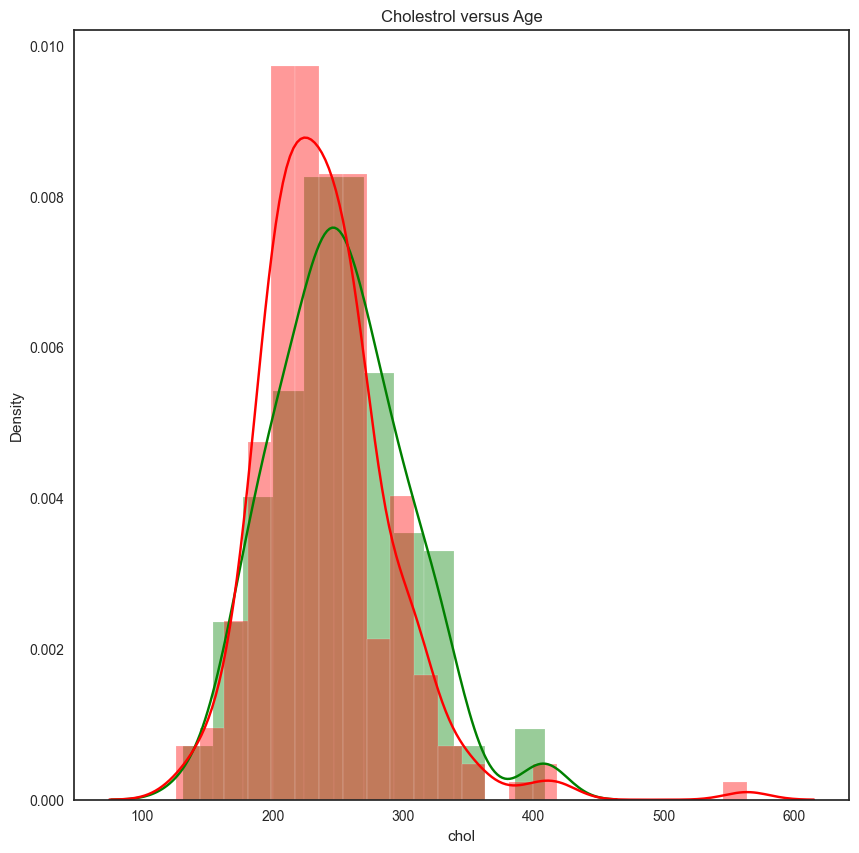

In [2579]:
plt.figure(figsize=(10,10))
sns.distplot(dfOG[dfOG['output'] == 0]["chol"], color='green',kde=True,)
sns.distplot(dfOG[dfOG['output'] == 1]["chol"], color='red',kde=True)
plt.title('Cholestrol versus Age')
plt.show()

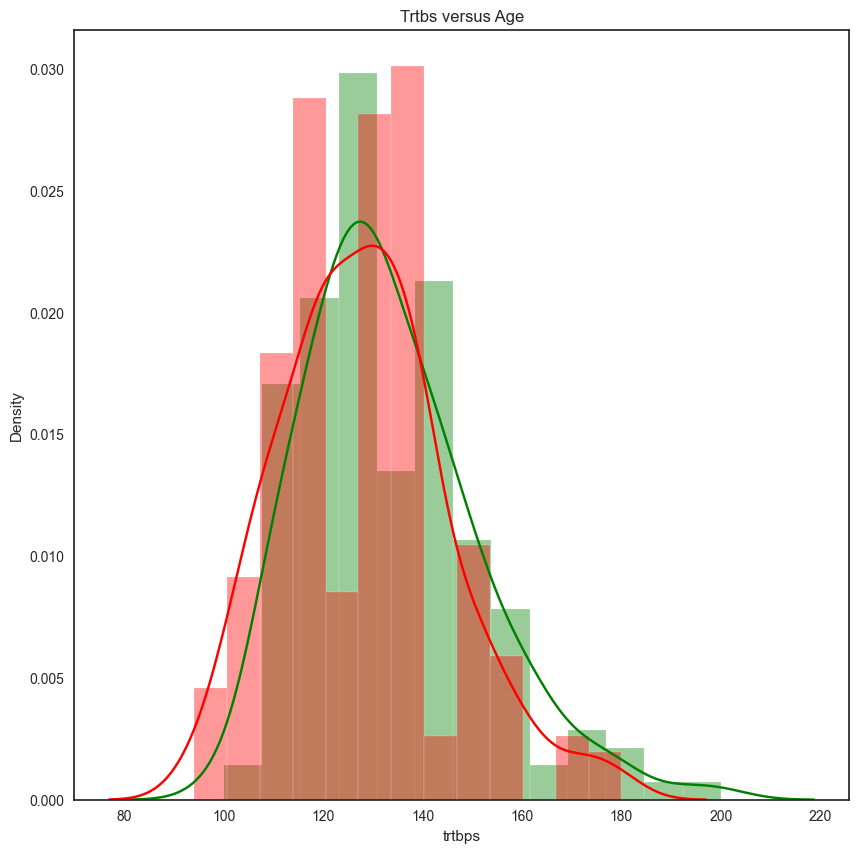

In [2580]:
plt.figure(figsize=(10,10))
sns.distplot(dfOG[dfOG['output'] == 0]["trtbps"], color='green',kde=True,)
sns.distplot(dfOG[dfOG['output'] == 1]["trtbps"], color='red',kde=True)
plt.title('Trtbs versus Age')
plt.show()

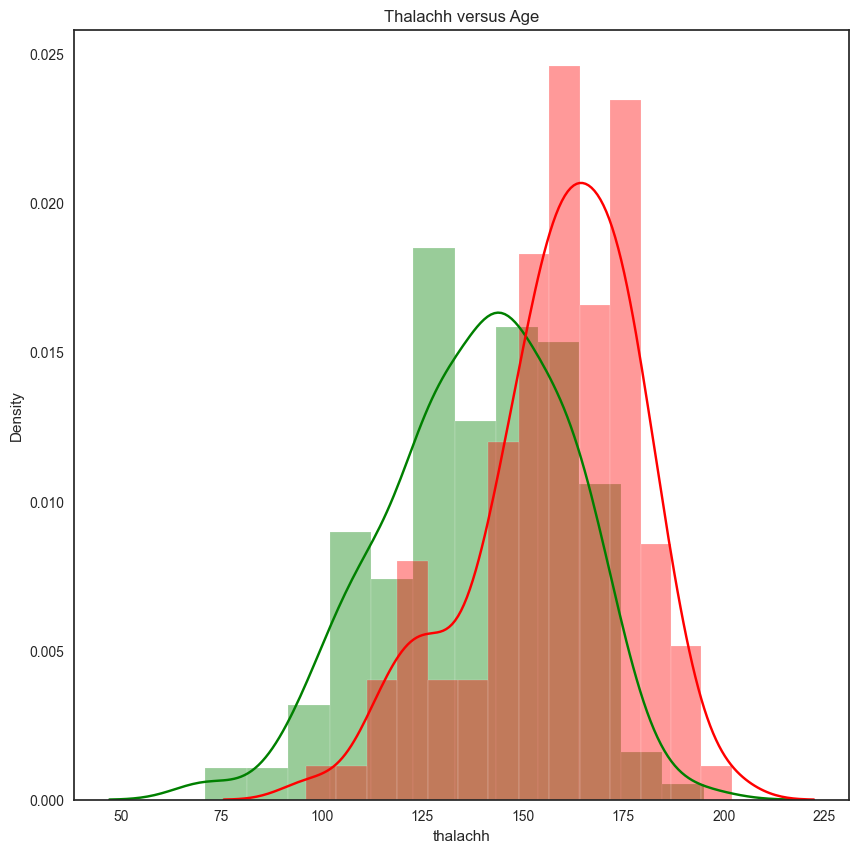

In [2581]:
plt.figure(figsize=(10,10))
sns.distplot(dfOG[dfOG['output'] == 0]["thalachh"], color='green',kde=True,)
sns.distplot(dfOG[dfOG['output'] == 1]["thalachh"], color='red',kde=True)
plt.title('Thalachh versus Age')
plt.show()

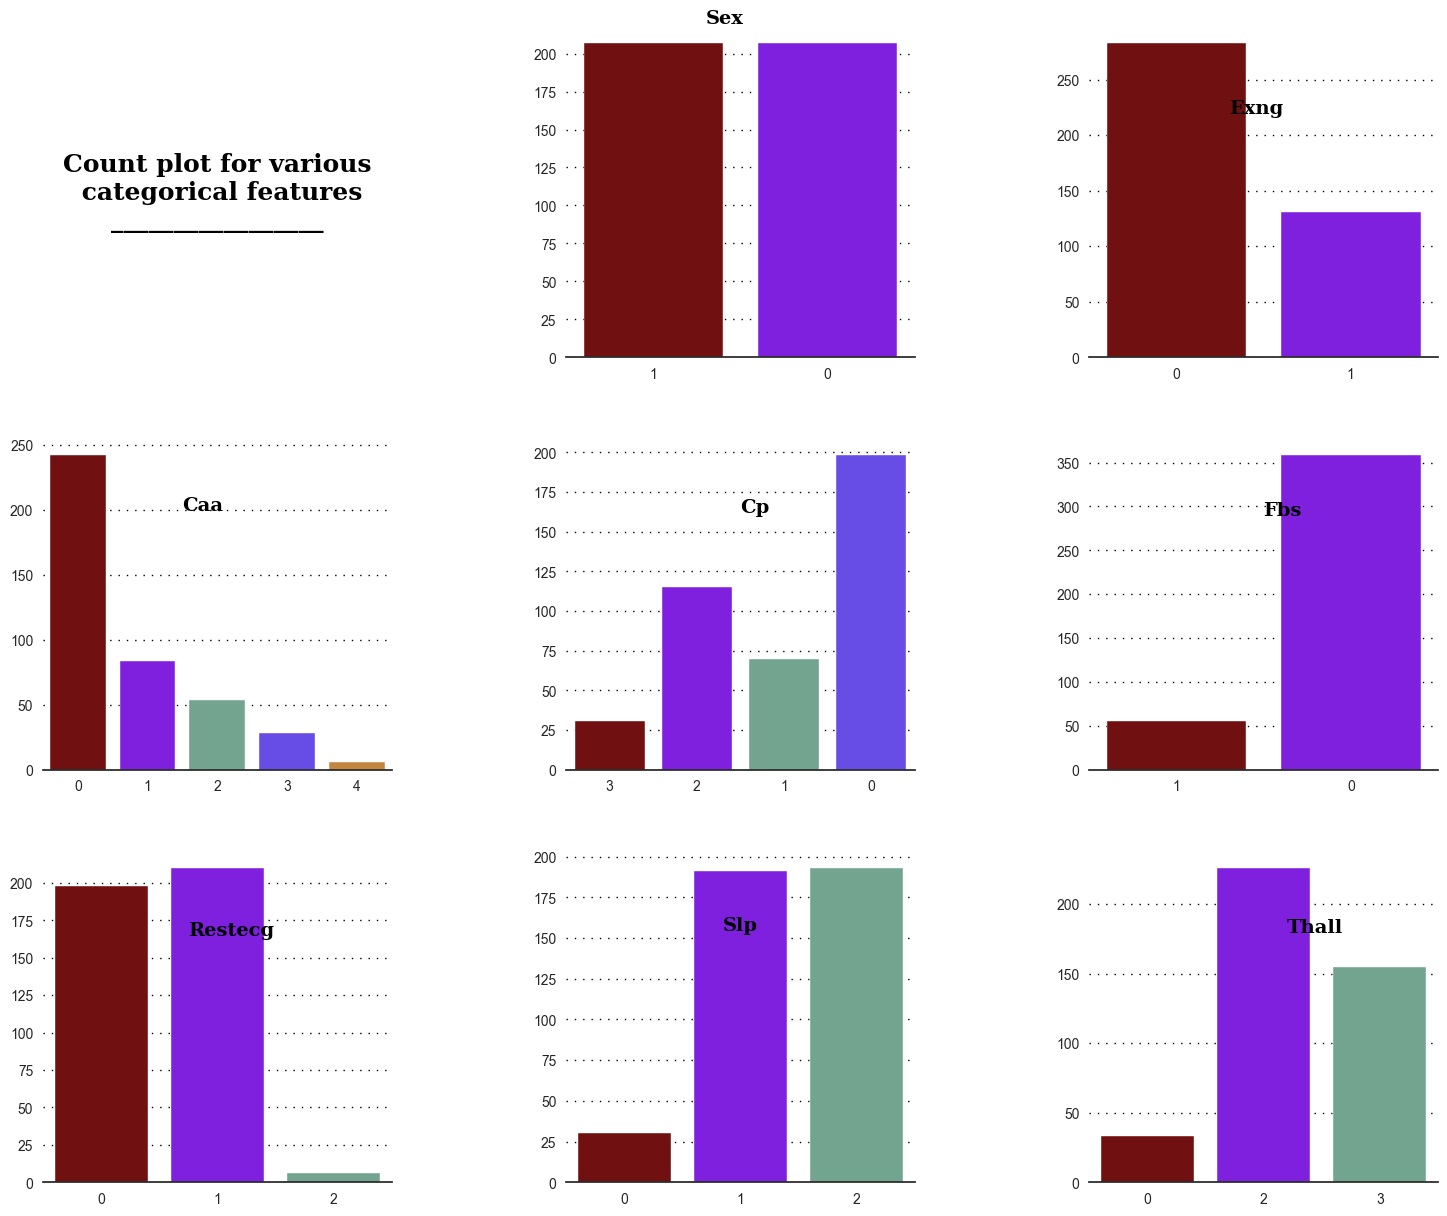

In [2582]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

# Background color
#White #ffffff
background_color = "#ffffff"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)
ax6.set_facecolor(background_color)
ax7.set_facecolor(background_color)
ax8.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Sex count
ax1.text(0.3, 220, 'Sex', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=dfOG,x='sex',palette=color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.text(0.3, 220, 'Exng', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=dfOG,x='exng',palette=color_palette)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.text(1.5, 200, 'Caa', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3,data=dfOG,x='caa',palette=color_palette)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.text(1.5, 162, 'Cp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4,data=dfOG,x='cp',palette=color_palette)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.text(0.5, 290, 'Fbs', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=dfOG,x='fbs',palette=color_palette)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.text(0.75, 165, 'Restecg', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6,data=dfOG,x='restecg',palette=color_palette)
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.text(0.85, 155, 'Slp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7,data=dfOG,x='slp',palette=color_palette)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.text(1.2, 180, 'Thall', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax8,data=dfOG,x='thall',palette=color_palette)
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

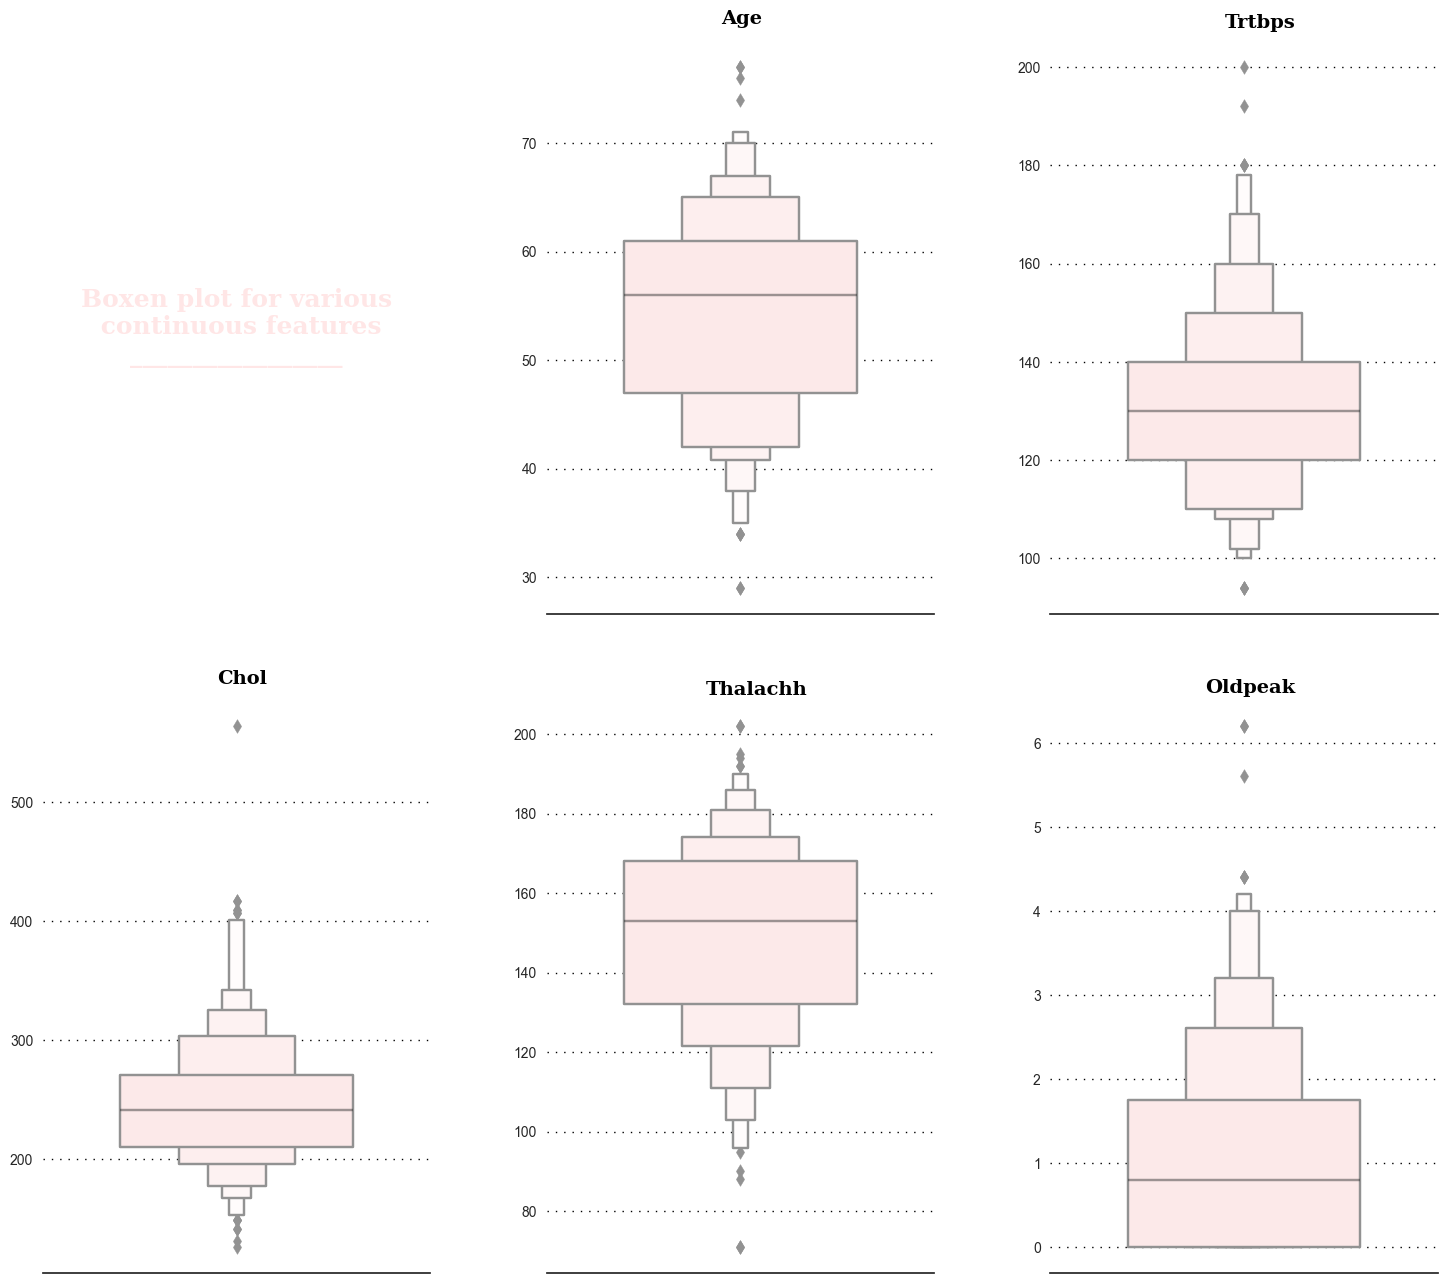

In [2583]:
fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

background_color = "#ffffff"
color_palette = ["#ffe6e6","#ffe6e6","#ffe6e6","#ffe6e6","#ffe6e6"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)
ax4.set_facecolor(background_color)
ax5.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Boxen plot for various\n continuous features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#ffe6e6")

# Age
ax1.text(-0.05, 81, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=dfOG['age'],palette=["#ffe6e6"],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Trtbps
ax2.text(-0.05, 208, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=dfOG['trtbps'],palette=["#ffe6e6"],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol
ax3.text(-0.05, 600, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=dfOG['chol'],palette=["#ffe6e6"],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh
ax4.text(-0.09, 210, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=dfOG['thalachh'],palette=["#ffe6e6"],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak
ax5.text(-0.1, 6.6, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=dfOG['oldpeak'],palette=["#ffe6e6"],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

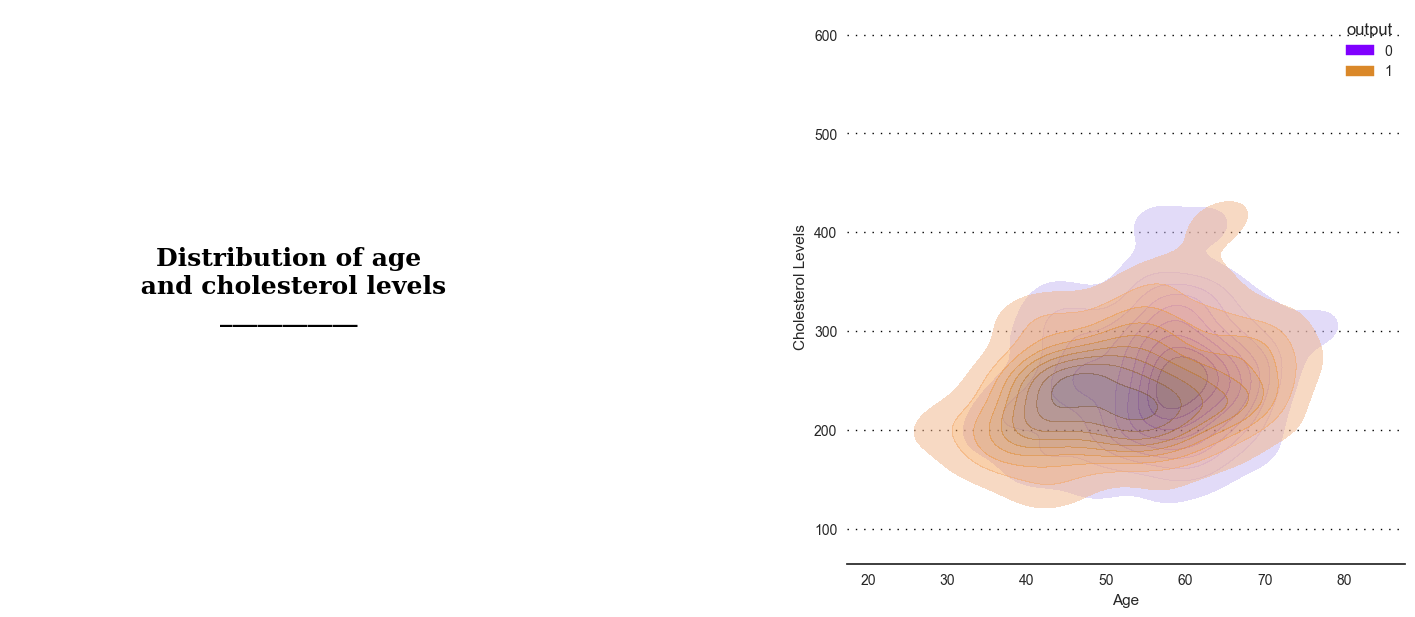

In [2584]:
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(2,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


background_color = "#ffffff"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)


# Age title
ax0.text(0.5,0.5,"Distribution of age\n and cholesterol levels\n___________",
         horizontalalignment = 'center',
         verticalalignment = 'center',
         fontsize = 18,
         fontweight='bold',
         fontfamily='serif',
         color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Age
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=dfOG, x='age',y=dfOG['chol'],hue="output", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax1.set_xlabel("Age")
ax1.set_ylabel("Cholesterol Levels")



for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)





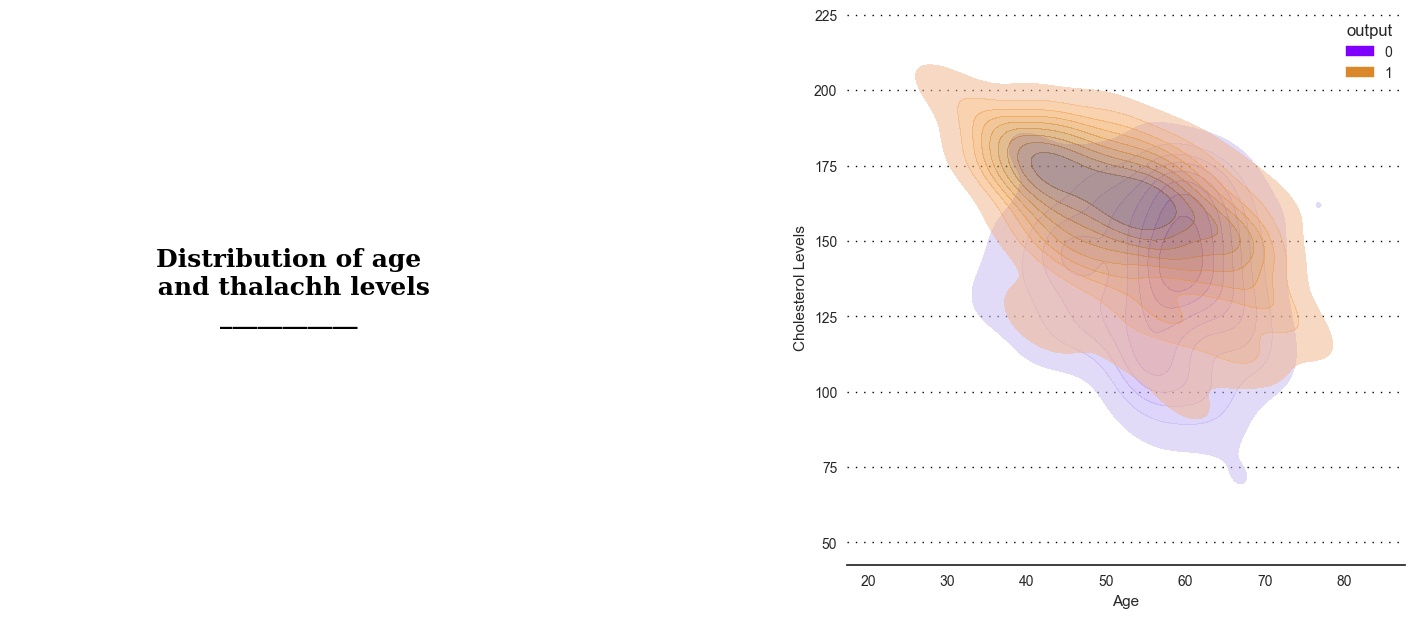

In [2585]:
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(2,2)
gs.update(wspace=0.5, hspace=0.5)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


background_color = "#ffffff"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)


# Age title
ax0.text(0.5,0.5,"Distribution of age\n and thalachh levels\n___________",
         horizontalalignment = 'center',
         verticalalignment = 'center',
         fontsize = 18,
         fontweight='bold',
         fontfamily='serif',
         color='#000000')
ax0.spines["bottom"].set_visible(False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Age
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=ax1, data=dfOG, x='age',y=dfOG['thalachh'],hue="output", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
ax1.set_xlabel("Age")
ax1.set_ylabel("Cholesterol Levels")



for i in ["top","left","right"]:
    ax0.spines[i].set_visible(False)
    ax1.spines[i].set_visible(False)





Correlation between Age and Cholesterol is : 0.2259052767399314


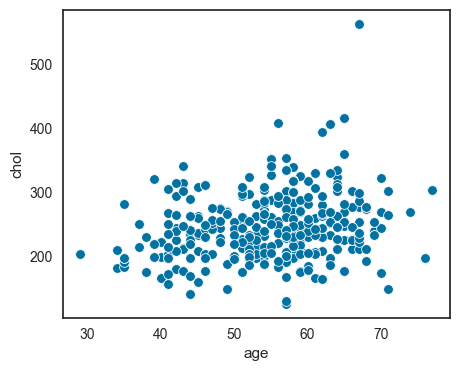

In [2586]:
sns.scatterplot(x=dfOG['age'],y=dfOG['chol'])
print("Correlation between Age and Cholesterol is :", dfOG["age"].corr(dfOG["chol"]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


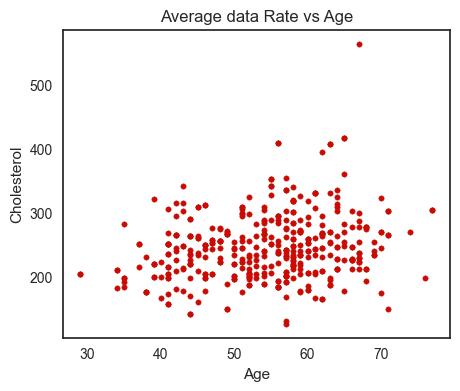

In [2587]:
plt.scatter(x=dfOG['age'],y=dfOG['chol'],c='r',s=15)
plt.legend()
plt.title('Average data Rate vs Age')
plt.xlabel("Age")
plt.ylabel("Cholesterol")
ax1.set_ylabel("Cholesterol Levels")
plt.show()

<AxesSubplot: xlabel='age'>

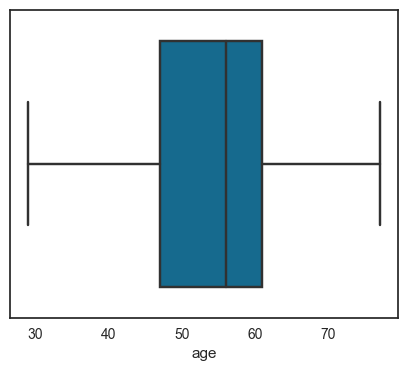

In [2588]:
sns.boxplot(x=dfOG['age'])

<AxesSubplot: xlabel='chol'>

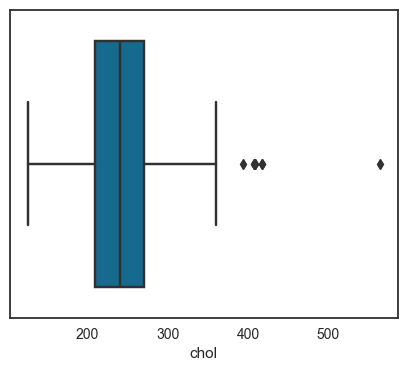

In [2589]:
sns.boxplot(x=dfOG['chol'])

<AxesSubplot: xlabel='age', ylabel='chol'>

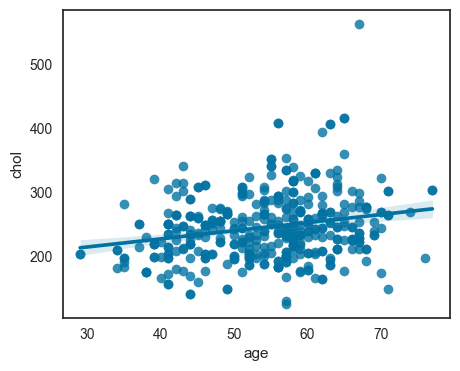

In [2590]:
sns.regplot(x='age',y='chol',data=dfOG,fit_reg=True)

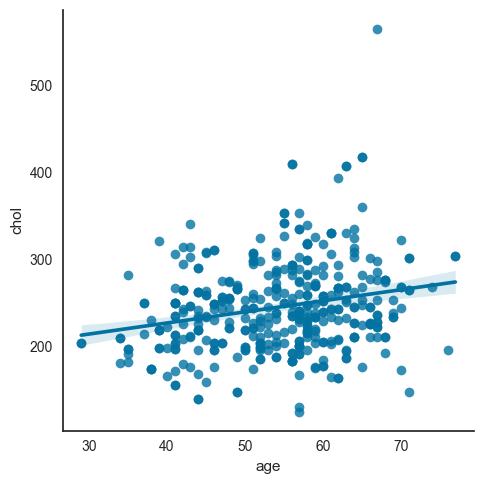

In [2591]:
sns.lmplot(x='age',y='chol',data=dfOG)

In [2592]:
ageGroups = pd.cut(dfOG['age'], 5)

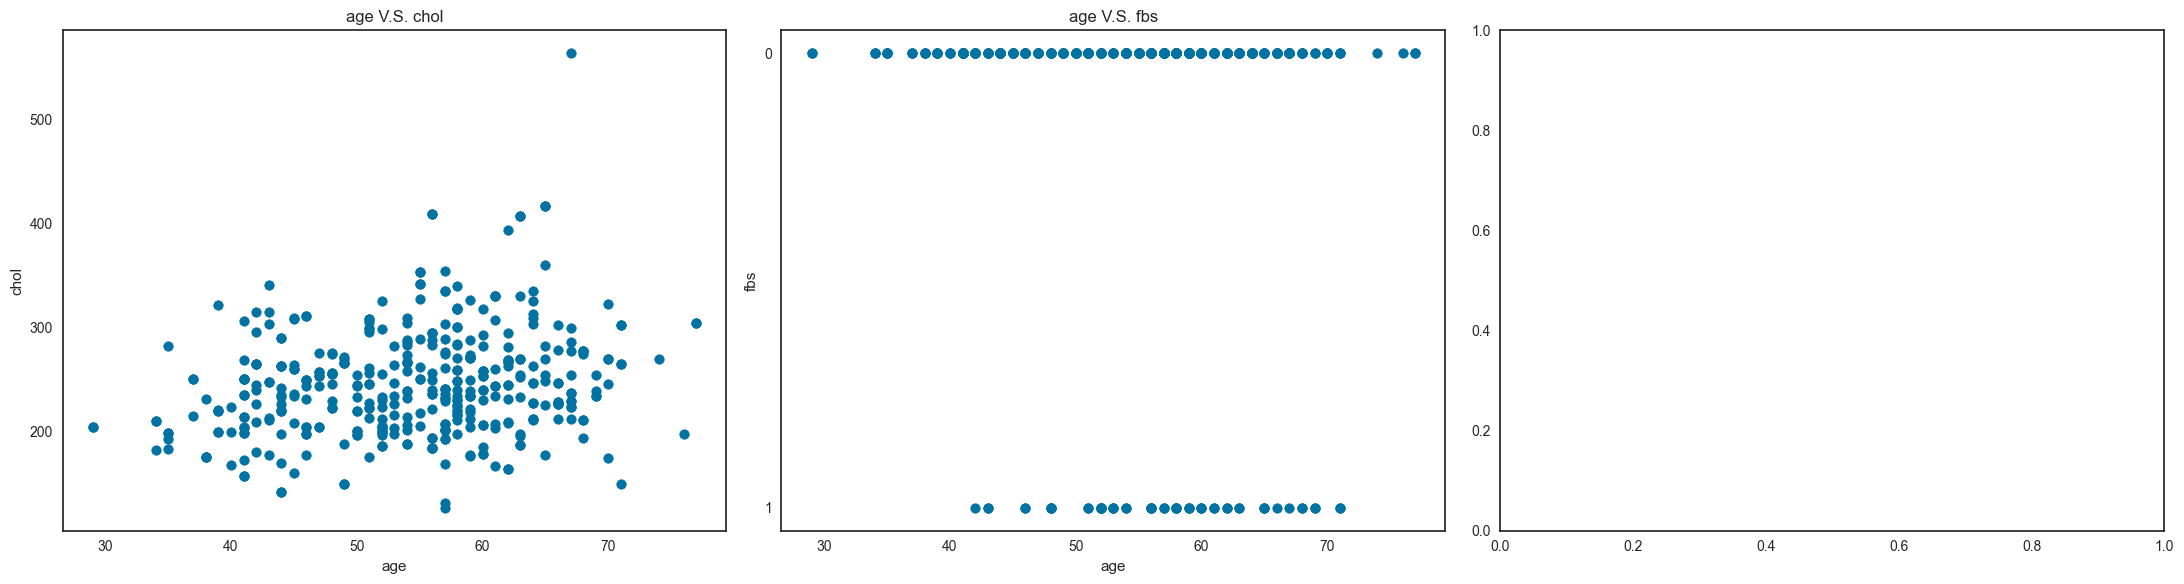

In [2593]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.scatter('age','chol',data=dfOG)
ax1.set(title='age V.S. chol', ylabel='chol',xlabel='age')
ax2.scatter('age','fbs',data=dfOG)
ax2.set(title='age V.S. fbs', ylabel='fbs',xlabel='age')
# ax3.scatter('age','trestbps',data=dfOG)
# ax3.set(title='age V.S. cp', ylabel='trestbps',xlabel='age')
plt.tight_layout()
plt.show()

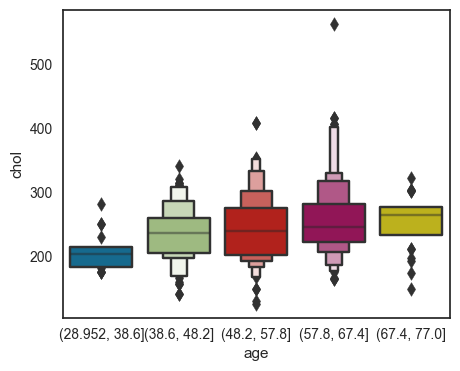

In [2594]:
sns.boxenplot(x=ageGroups, y="chol", data=dfOG)
plt.show()

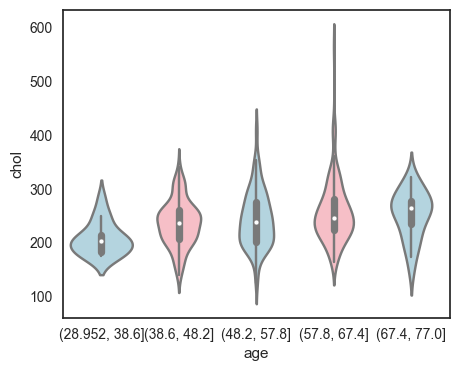

In [2595]:

sns.violinplot(x=ageGroups, y="chol", palette=["lightblue", "lightpink"], data=dfOG)
plt.show()

<AxesSubplot: xlabel='age', ylabel='restecg'>

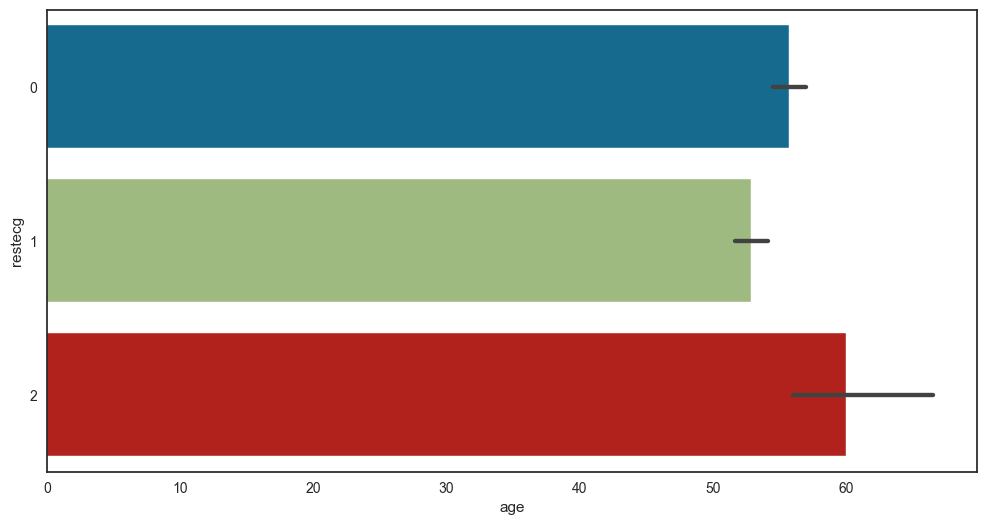

In [2596]:
plt.figure(figsize=(12,6))

sns.barplot(y =dfOG['restecg'], x =dfOG['age'])

Augment the Dataset to Add more Values

In [2597]:
#AUGMENT THE DATA
#Generate 1000 new rows of data
augmentedData = dfOG.sample(n=5000, replace=True, random_state=529)

#Add the new rows to the original data
dfOG = dfOG.append(augmentedData)

#Shuffle the data
dfOG = dfOG.sample(frac=1, random_state=529).reset_index(drop=True)


In [2598]:
#Split the data into training and testing

#Split into two csv files for training and testing
df_train = dfOG.sample(frac=0.8, random_state=42)
df_test = dfOG.drop(df_train.index)

#Save the dataframes to csv files
df_train.to_csv('heart_train.csv', index=False)
df_test.to_csv('heart_test.csv', index=False)





In [2599]:
df_train = pd.read_csv('heart_train.csv')
df_train.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,41,0,2,112,250,0,1,179,0,0.0,2,0,2,1
1,49,0,1,130,266,0,1,171,0,0.6,2,0,2,1
2,59,1,0,170,326,0,0,140,1,3.4,0,0,3,0
3,60,0,3,150,240,0,1,171,0,0.9,2,0,2,1
4,62,1,2,130,231,0,1,146,0,1.8,1,3,3,1


In [2600]:
df_test = pd.read_csv('heart_test.csv')
df_test.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,66,0,1,160,246,0,1,120,1,0.0,1,3,0,0
1,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1
2,47,0,2,138,257,0,0,156,0,0.0,2,0,2,1
3,64,0,0,145,212,0,0,132,0,2.0,1,2,0,0
4,56,1,1,120,240,0,1,169,0,0.0,0,0,2,1


In [2601]:
df_train2 = df_train[['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall','output']]
df_train2

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,41,0,2,112,250,0,1,179,0,0.0,2,0,2,1
1,49,0,1,130,266,0,1,171,0,0.6,2,0,2,1
2,59,1,0,170,326,0,0,140,1,3.4,0,0,3,0
3,60,0,3,150,240,0,1,171,0,0.9,2,0,2,1
4,62,1,2,130,231,0,1,146,0,1.8,1,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4326,49,0,1,130,266,0,1,171,0,0.6,2,0,2,1
4327,62,0,0,150,244,0,1,154,1,1.4,1,0,2,0
4328,63,1,0,130,330,1,0,132,1,1.8,2,3,3,0
4329,42,1,0,140,226,0,1,178,0,0.0,2,0,2,1


In [2602]:
df_test2 = df_test[['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall','output']]
df_test2

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,66,0,1,160,246,0,1,120,1,0.0,1,3,0,0
1,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1
2,47,0,2,138,257,0,0,156,0,0.0,2,0,2,1
3,64,0,0,145,212,0,0,132,0,2.0,1,2,0,0
4,56,1,1,120,240,0,1,169,0,0.0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1078,46,0,1,105,204,0,1,172,0,0.0,2,0,2,1
1079,43,1,0,110,211,0,1,161,0,0.0,2,0,3,1
1080,51,0,2,140,308,0,0,142,0,1.5,2,1,2,1
1081,35,1,0,120,198,0,1,130,1,1.6,1,0,3,0


In [2603]:
df_train2_np = df_train2.to_numpy()
X_train, y_train = df_train2_np[:, :-1], df_train2_np[:, -1]
X_train.shape, y_train.shape

((4331, 13), (4331,))

In [2604]:
X_trainDF, y_trainDF = df_train2.iloc[:, :-1], df_train2.iloc[:, -1]
X_trainDF.shape, y_trainDF.shape

((4331, 13), (4331,))

Models


In [2605]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

#train the model
model = LinearSVC()
model.fit(X_train, y_train)




LinearSVC()

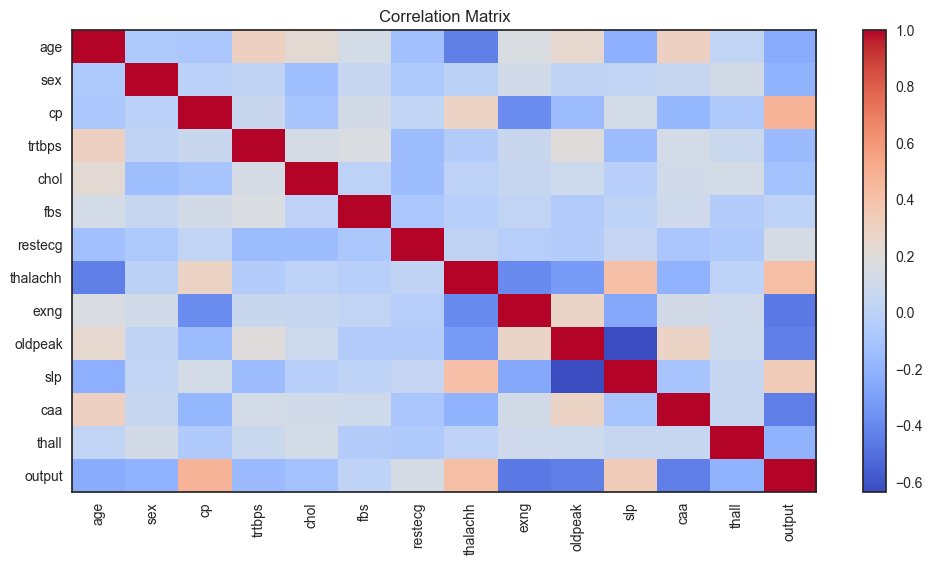

In [2606]:
#Generate a correlation matrix
corr = df_train2.corr()

#plot the correlation matrix
plt.figure(figsize=(12,6))
plt.title('Correlation Matrix')
plt.imshow(corr,cmap='coolwarm',interpolation='none',aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)),corr.columns,rotation='vertical')
plt.yticks(range(len(corr)),corr.columns)
plt.show()

In [2607]:
from sklearn.cluster import KMeans

print (df_train2.head())


   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   41    0   2     112   250    0        1       179     0      0.0    2   
1   49    0   1     130   266    0        1       171     0      0.6    2   
2   59    1   0     170   326    0        0       140     1      3.4    0   
3   60    0   3     150   240    0        1       171     0      0.9    2   
4   62    1   2     130   231    0        1       146     0      1.8    1   

   caa  thall  output  
0    0      2       1  
1    0      2       1  
2    0      3       0  
3    0      2       1  
4    3      3       1  


In [2608]:
df_train2.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 entries, 0 to 4330
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       4331 non-null   int64  
 1   sex       4331 non-null   int64  
 2   cp        4331 non-null   int64  
 3   trtbps    4331 non-null   int64  
 4   chol      4331 non-null   int64  
 5   fbs       4331 non-null   int64  
 6   restecg   4331 non-null   int64  
 7   thalachh  4331 non-null   int64  
 8   exng      4331 non-null   int64  
 9   oldpeak   4331 non-null   float64
 10  slp       4331 non-null   int64  
 11  caa       4331 non-null   int64  
 12  thall     4331 non-null   int64  
 13  output    4331 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 473.8 KB


In [2609]:
plt.figure()

<Figure size 500x400 with 0 Axes>

<Figure size 500x400 with 0 Axes>

In [2610]:
dataCopy = df_train2.copy()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

dataScaled = scaler.fit_transform(dataCopy)

dataScaled = pd.DataFrame(dataScaled, columns=dataCopy.columns)
dataScaled.head()


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,-1.446596,-0.985103,1.027842,-1.053389,0.088201,-0.398298,0.858760,1.259376,-0.68566,-0.895655,0.970690,-0.729521,-0.254645,0.890299
1,-0.575385,-0.985103,0.061157,-0.037215,0.400389,-0.398298,0.858760,0.918420,-0.68566,-0.396095,0.970690,-0.729521,-0.254645,0.890299
2,0.513630,1.015122,-0.905528,2.220951,1.571091,-0.398298,-1.030163,-0.402784,1.45845,1.935183,-2.269432,-0.729521,0.976233,-1.123218
3,0.622531,-0.985103,1.994527,1.091868,-0.106916,-0.398298,0.858760,0.918420,-0.68566,-0.146315,0.970690,-0.729521,-0.254645,0.890299
4,0.840334,1.015122,1.027842,-0.037215,-0.282521,-0.398298,0.858760,-0.147067,-0.68566,0.603024,-0.649371,2.169154,0.976233,0.890299


In [2611]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

pca = SparsePCA(n_components=3)

dataPCA = pca.fit_transform(dataScaled)

dataPCA = pd.DataFrame(dataPCA, columns=['PC1', 'PC2', 'PC3'])

dataPCA.head()

,PC1,PC2,PC3
0,-2.256908,-1.211594,1.031645
1,-1.475140,-0.466830,0.877127
2,2.761933,1.385251,-1.196902
3,-1.339333,0.975981,1.794895
4,0.346027,0.594452,0.020711


In [2612]:
dataPCA.describe()

,PC1,PC2,PC3
count,4.331000e+03,4.331000e+03,4.331000e+03
mean,7.218629e-17,6.931524e-17,1.230448e-17
std,1.670175e+00,1.251802e+00,1.255312e+00
min,-3.291364e+00,-2.708018e+00,-3.067697e+00
25%,-1.373151e+00,-8.302629e-01,-8.502792e-01
50%,-2.408257e-01,-1.878283e-01,5.268055e-02
75%,1.358651e+00,8.846539e-01,8.706959e-01
max,4.378630e+00,3.808806e+00,3.394758e+00


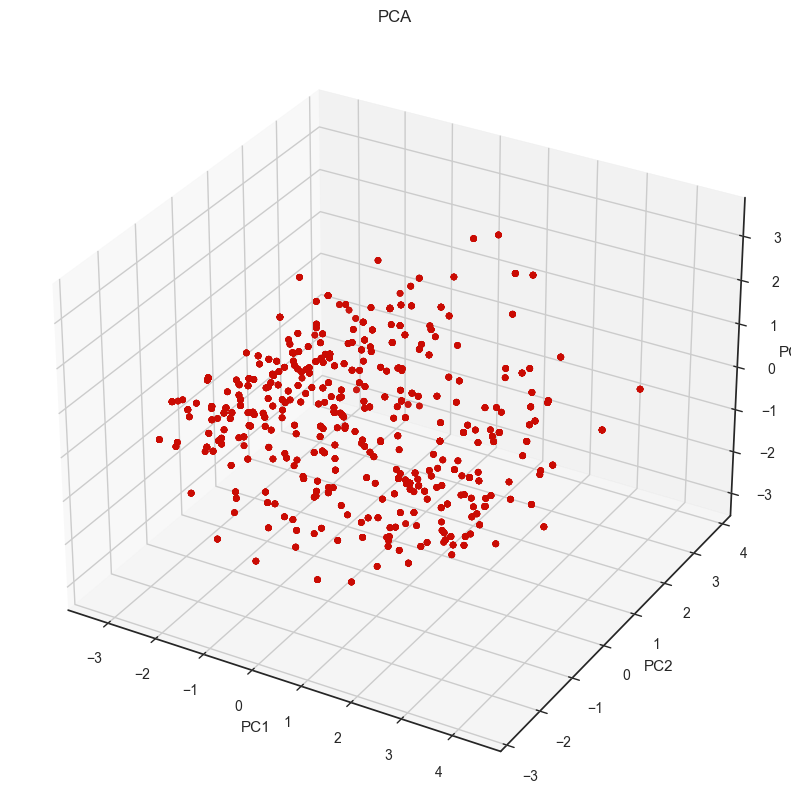

In [2613]:
#Plot the data in 3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataPCA['PC1'], dataPCA['PC2'], dataPCA['PC3'], c='r', marker='o')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA')
plt.show()


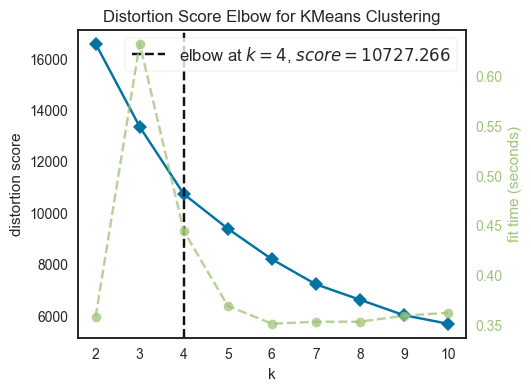

In [2614]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(10))

visualizer.fit(dataPCA)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


clusterCount = visualizer.elbow_value_


In [2615]:
print (clusterCount)

4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


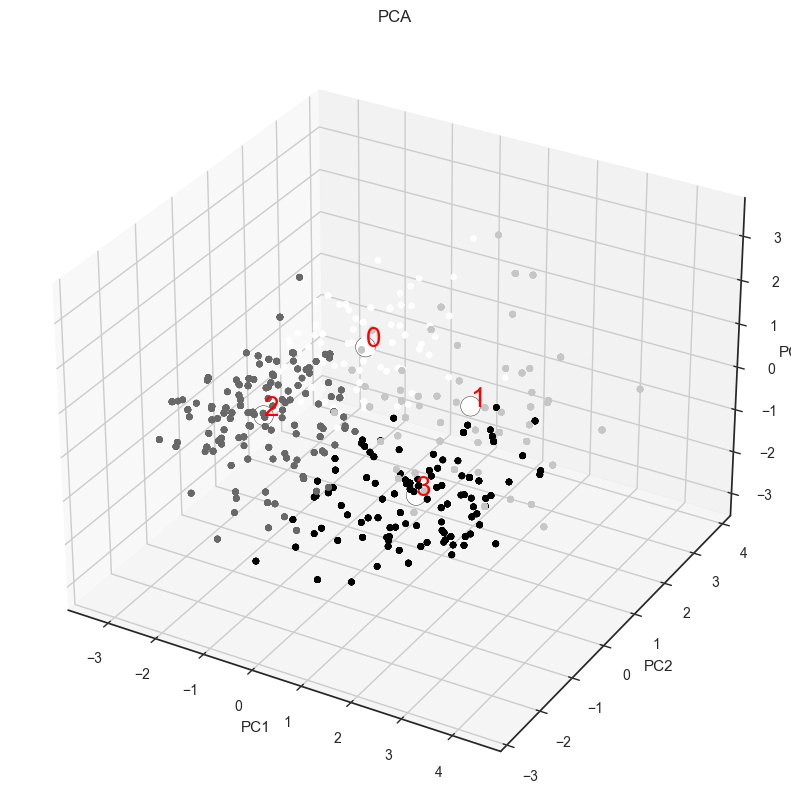

In [2616]:
model = KMeans(n_clusters=clusterCount)
prediction = model.fit_predict(dataPCA)

dataPCA['Cluster'] = prediction

x,y,z = dataPCA['PC1'], dataPCA['PC2'], dataPCA['PC3']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x, y, z, c=dataPCA['Cluster'], marker='o')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


# Identify the cluster centers
centers = model.cluster_centers_
# Draw white circles at cluster centers
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           c='white', alpha=1, s=200, edgecolor='k')


# Identify what each cluster represents
for i, c in enumerate(centers):
    ax.text(c[0], c[1], c[2], str(i), fontsize=20, color='red')






ax.legend()
plt.title('PCA')
plt.show()


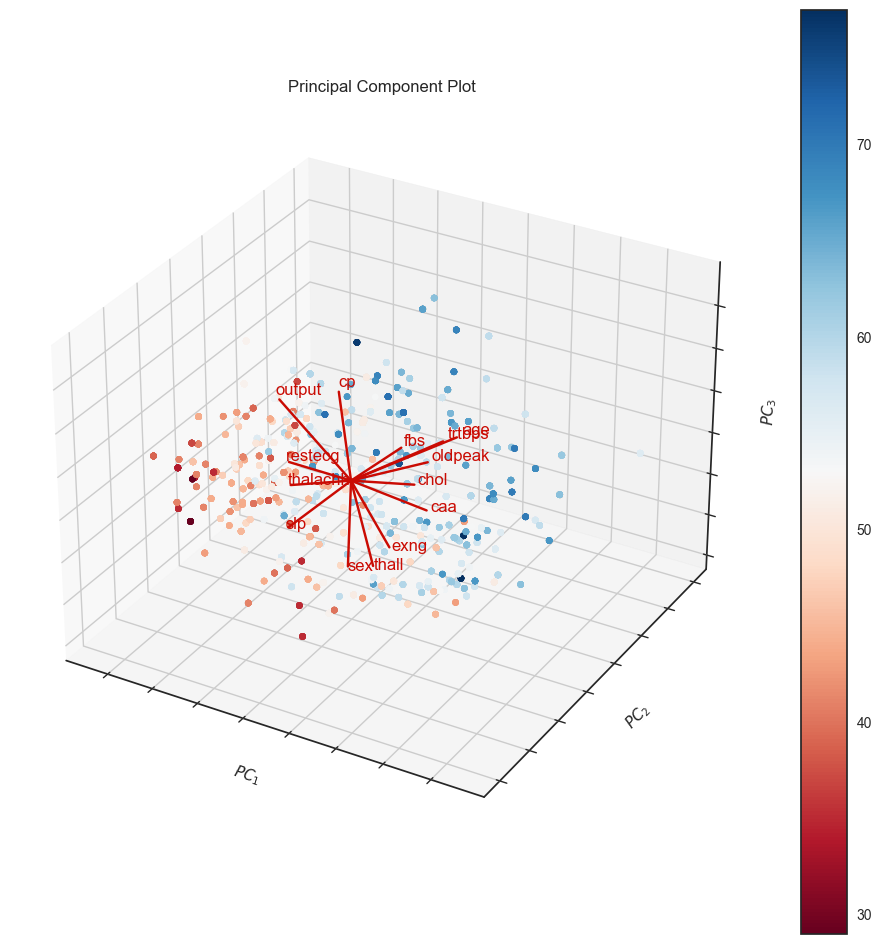

<Axes3DSubplot: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$', zlabel='$PC_3$'>

In [2617]:
from yellowbrick.features import PCA

X, y = df_train2, df_train2['age']

# Make the graph larger.
plt.figure(figsize=(12, 12))

visualizer = PCA(scale=True, proj_features=True, projection=3)

visualizer.fit_transform(X, y)
visualizer.show()

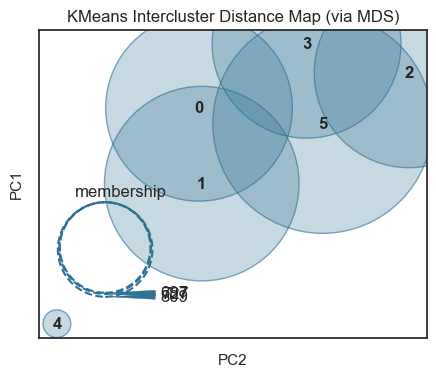

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [2618]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import InterclusterDistance

X, y = df_train2, df_train2['age']

# Instantiate the clustering model and visualizer
model = KMeans(6)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

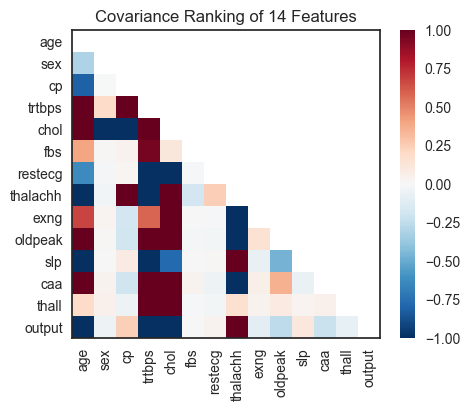

<AxesSubplot: title={'center': 'Covariance Ranking of 14 Features'}>

In [2619]:
#Utilise Yellowbrick to visualise the data
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(algorithm='covariance')

visualizer.fit(df_train2)           # Fit the data to the visualizer
visualizer.transform(df_train2)        # Transform the data

visualizer.poof()        # Draw/show/poof the data




In [2620]:
from sklearn.metrics import r2_score
from skimage.metrics import mean_squared_error


#Create evaluations depending on the model used.

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R2: {r2:.2f}')


#ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()



def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()





In [2621]:
bestErrorVal = 100
bestModel = ""

def bestError(trainError, modelName):
    print("Train Error: ", trainError, "Model Name: ", modelName)
    global bestErrorVal
    global bestModel
    if trainError < bestErrorVal:
        print("Best Model: ", modelName, "Best Error: ", trainError)
        bestErrorVal = trainError
        bestModel = modelName


def getBestModel():
    global bestErrorVal
    global bestModel

    return  bestModel,bestErrorVal


In [2622]:
df_test2_np = df_test2.to_numpy()
X_test, y_test = df_test2_np[:, :-1], df_test2_np[:, -1]
X_test.shape, y_test.shape

((1083, 13), (1083,))

In [2623]:
x_testDf, y_testDf = df_test2.iloc[:, :-1], df_test2.iloc[:, -1]
x_testDf.shape, y_testDf.shape

((1083, 13), (1083,))

0.26828749672571295 0.27277992339388296
MAE: 0.27
MSE: 0.11
RMSE: 0.34
R2: 0.54


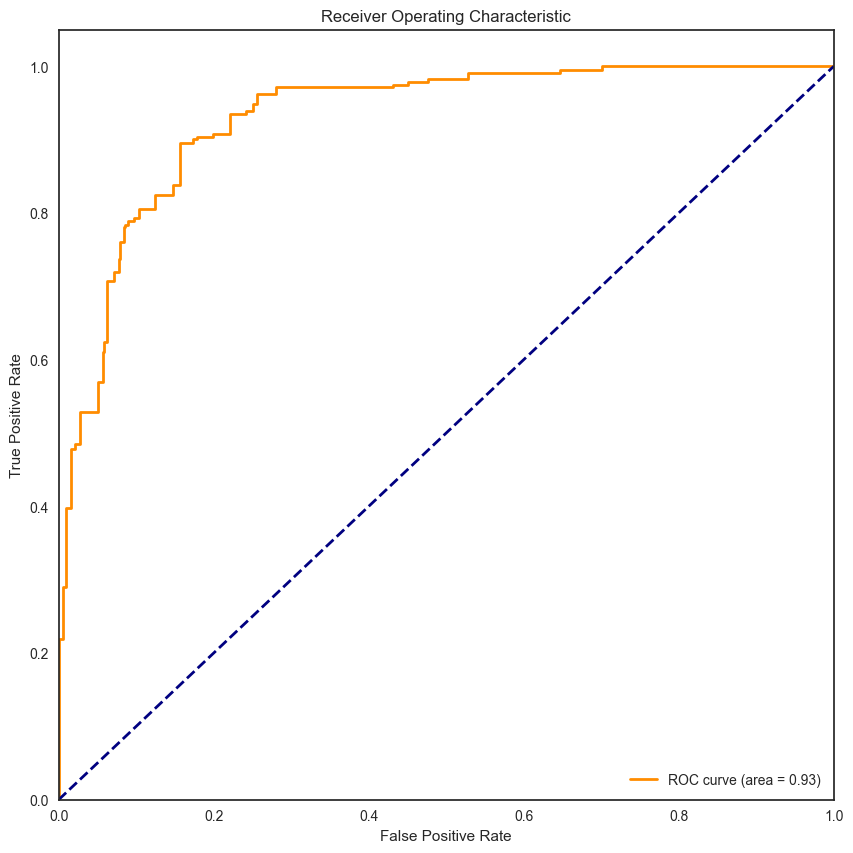

Train Error:  0.27277992339388296 Model Name:  Linear Regression
Best Model:  Linear Regression Best Error:  0.27277992339388296


In [2624]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

linear_model = LinearRegression().fit(X_train, y_train)
linear_train_preds = linear_model.predict(X_train)
linear_test_preds = linear_model.predict(X_test)
#print(mean_absolute_error(linear_train_preds, y_train))

trainError = mean_absolute_error(linear_train_preds, y_train)
testError = mean_absolute_error(linear_test_preds, y_test)
print(trainError, testError)
#Evaluate the model
evaluate_model(y_train, linear_train_preds)
plot_roc_curve(y_train, linear_train_preds)
bestError(testError,"Linear Regression")



0.11347869256608151 0.11699929216900275
MAE: 0.12
MSE: 0.04
RMSE: 0.21
R2: 0.83


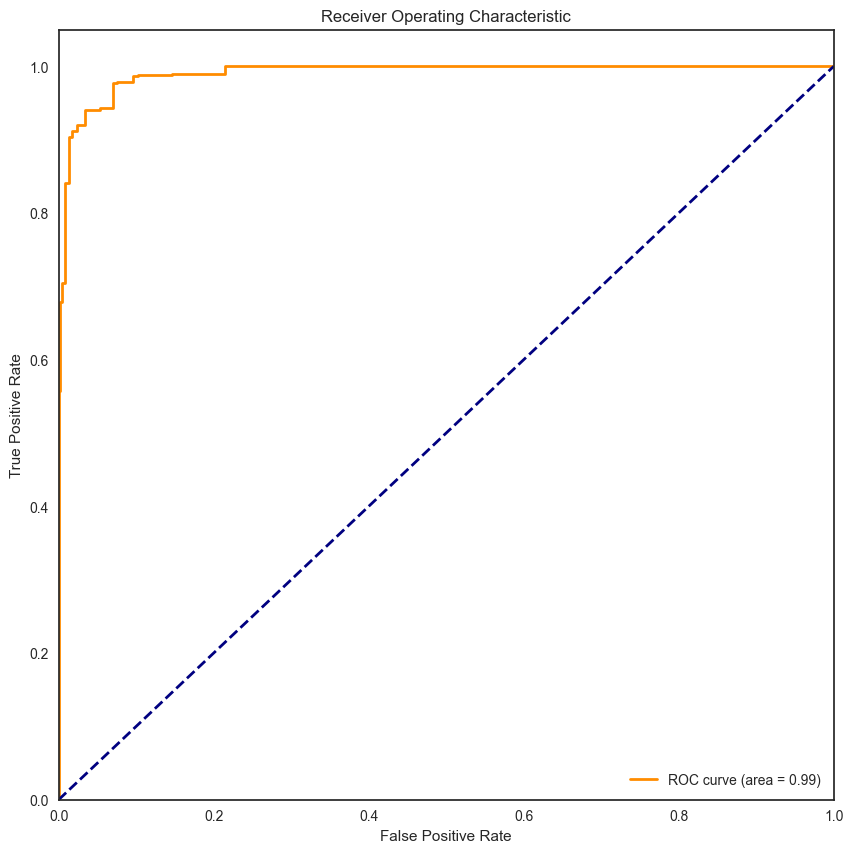

Train Error:  0.11699929216900275 Model Name:  Random Forest
Best Model:  Random Forest Best Error:  0.11699929216900275


In [2625]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
rf_train_preds = rf.predict(X_train)
rf_test_preds = rf.predict(X_test)

trainError = mean_absolute_error(rf_train_preds, y_train)
testError = mean_absolute_error(rf_test_preds, y_test)
print(trainError, testError)
evaluate_model(y_test, rf_test_preds)
plot_roc_curve(y_test, rf_test_preds)
bestError(testError,"Random Forest")
#Evaluate the model


0.11986815150025817 0.1235924860556083
MAE: 0.12
MSE: 0.03
RMSE: 0.18
R2: 0.86


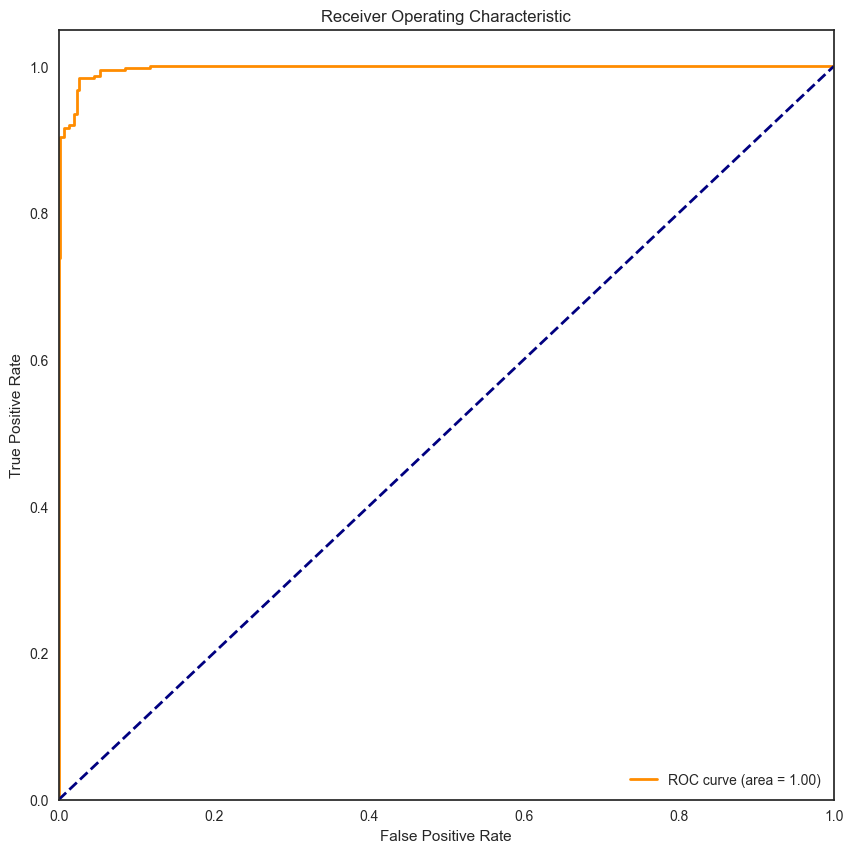

Train Error:  0.1235924860556083 Model Name:  Gradient Boosting


In [2626]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
gb.fit(X_train, y_train)
gb_train_preds = gb.predict(X_train)
gb_test_preds = gb.predict(X_test)

trainError = mean_absolute_error(gb_train_preds, y_train)
testError = mean_absolute_error(gb_test_preds, y_test)
print(trainError, testError)
evaluate_model(y_test, gb_test_preds)
plot_roc_curve(y_test, gb_test_preds)

bestError(testError,"Gradient Boosting")



0.22411449086666235 0.22981491504156282
MAE: 0.23
MSE: 0.09
RMSE: 0.29
R2: 0.65


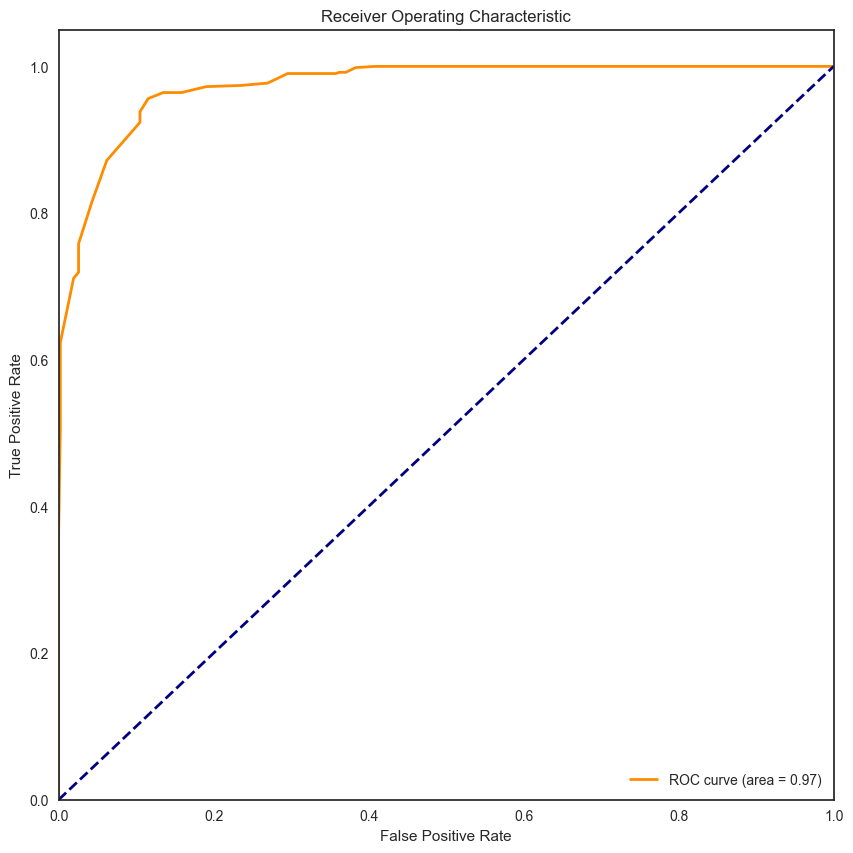

Train Error:  0.22981491504156282 Model Name:  Ada Boosting


In [2627]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor(n_estimators=100, random_state=42,learning_rate=1)
ada.fit(X_train, y_train)
ada_train_preds = ada.predict(X_train)
ada_test_preds = ada.predict(X_test)

trainError = mean_absolute_error(ada_train_preds, y_train)
testError = mean_absolute_error(ada_test_preds, y_test)
print(trainError, testError)
evaluate_model(y_test, ada_test_preds)
plot_roc_curve(y_test, ada_test_preds)
bestError(testError,"Ada Boosting")




0.33473215921201765 0.33727307889906694
MAE: 0.34
MSE: 0.18
RMSE: 0.42
R2: 0.28


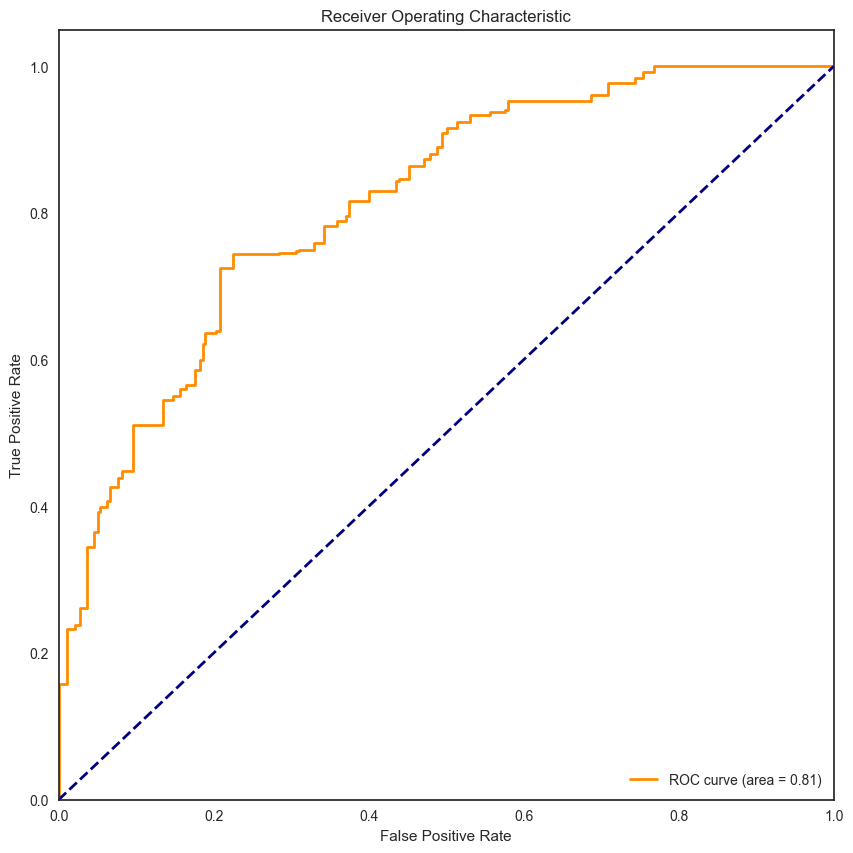

Train Error:  0.33727307889906694 Model Name:  Support Vector Regression


In [2628]:
#What other models can we use?
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
svr_train_preds = svr.predict(X_train)
svr_test_preds = svr.predict(X_test)

trainError = mean_absolute_error(svr_train_preds, y_train)
testError = mean_absolute_error(svr_test_preds, y_test)
print(trainError, testError)
evaluate_model(y_test, svr_test_preds)
plot_roc_curve(y_test, svr_test_preds)
bestError(testError,"Support Vector Regression")

0.0008312168090510275 0.00221606648199446
MAE: 0.00
MSE: 0.00
RMSE: 0.02
R2: 1.00


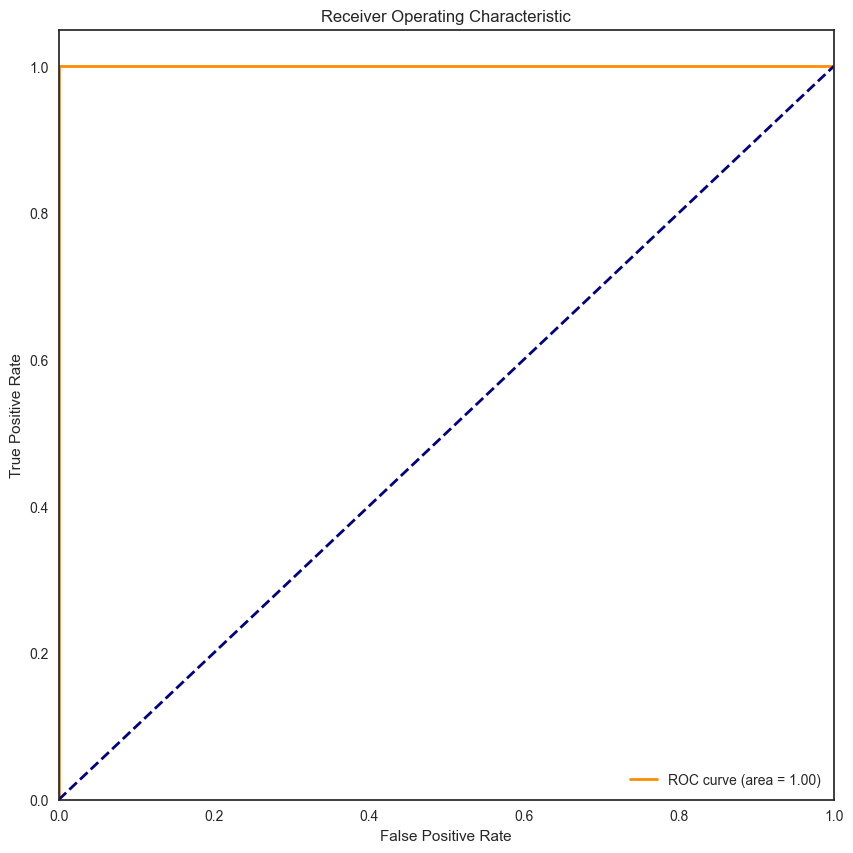

In [2629]:
#What other models can we use?
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5,weights='uniform')
knn.fit(X_train, y_train)
knn_train_preds = knn.predict(X_train)
knn_test_preds = knn.predict(X_test)

trainError = mean_absolute_error(knn_train_preds, y_train)
testError = mean_absolute_error(knn_test_preds, y_test)
print(trainError, testError)
evaluate_model(y_test, knn_test_preds)
plot_roc_curve(y_test, knn_test_preds)

#Exclusion of KNN, Not confident in the models' performance.

#bestError(testError,"KNN Regression")

In [2630]:
#Get the best error
getBestModel()




('Random Forest', 0.11699929216900275)

In [2631]:
#Find the best model
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

#Gradient Boosting
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'max_depth': 10, 'n_estimators': 200}

In [2632]:
#Random Forest
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'max_depth': 15, 'n_estimators': 300}

In [2633]:
#AdaBoost grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 9 candidates, totalling 27 fits


{'learning_rate': 0.1, 'n_estimators': 100}

In [2634]:
#KNN grid search
param_grid = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'n_neighbors': 5, 'weights': 'distance'}

In [2635]:
# #SVR grid search
# param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 1, 10, 100, 1000],
#     'gamma': ['scale', 'auto']
# }
#
# grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_


In [2636]:
from sklearn.model_selection import train_test_split

#Split into Test, Train, Val
X_val, X_hold,y_val,y_hold = train_test_split(X_test,y_test,test_size=1,random_state=42)

X_val.shape, X_hold.shape, y_val.shape, y_hold.shape



((1082, 13), (1, 13), (1082,), (1,))

0.27256926172361357 0.26828749672571295
MAE: 0.27
MSE: 0.11
RMSE: 0.34
R2: 0.53


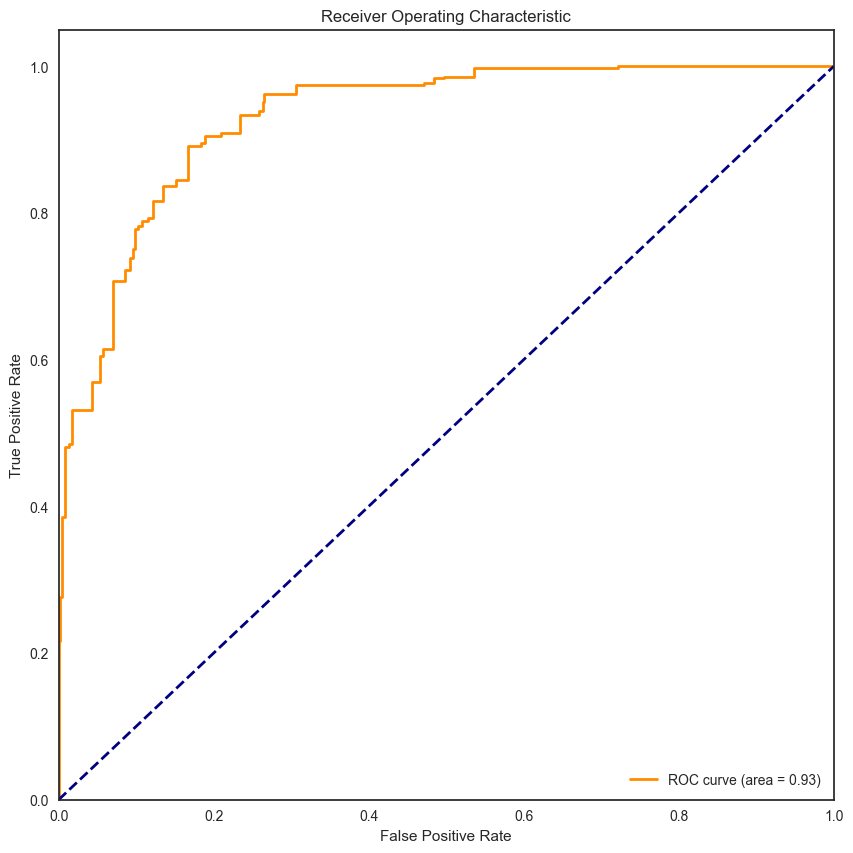

Train Error:  0.26828749672571295 Model Name:  Linear Regression


In [2637]:
linear_val_preds = linear_model.predict(X_val)

testError = mean_absolute_error(y_train,linear_train_preds)
trainError = mean_absolute_error(y_val,linear_val_preds)

print(trainError, testError)


evaluate_model(y_val, linear_val_preds)
plot_roc_curve(y_val, linear_val_preds)
bestError(testError,"Linear Regression")


0.11986815150025817 0.12356601332697012
MAE: 0.12
MSE: 0.03
RMSE: 0.18
R2: 0.86


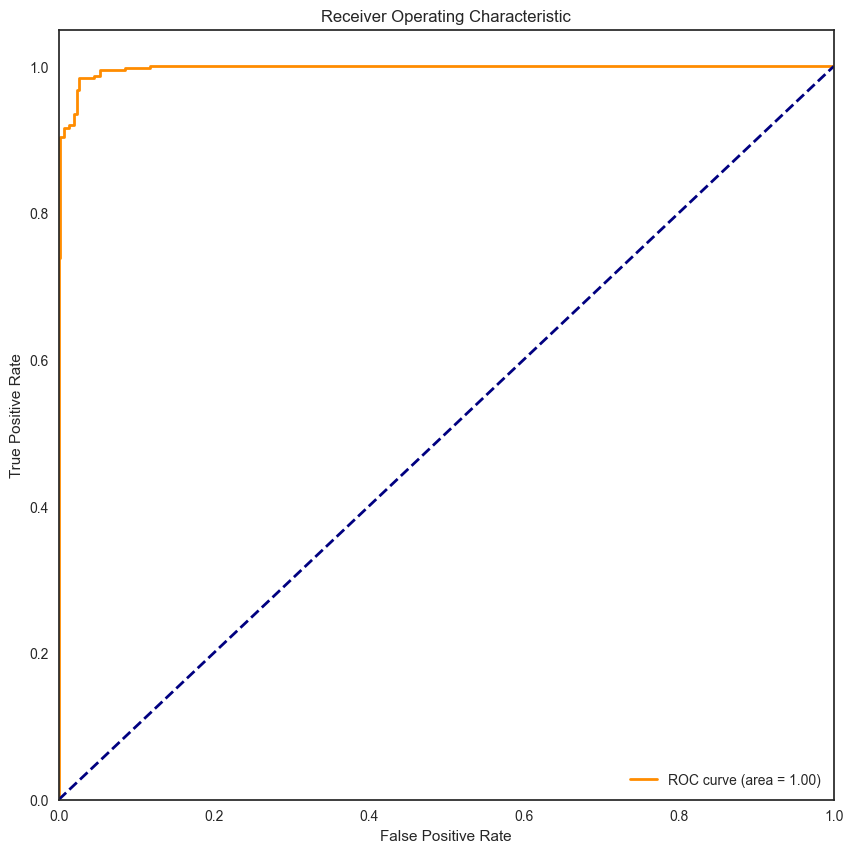

Train Error:  0.12356601332697012 Model Name:  Gradient Boosting


In [2638]:
#Gradient Boosting
gb_val_preds = gb.predict(X_val)

trainError = mean_absolute_error(y_train,gb_train_preds)
testError = mean_absolute_error(y_val,gb_val_preds)
print(trainError, testError)
evaluate_model(y_test, gb_test_preds)
plot_roc_curve(y_test, gb_test_preds)
bestError(testError,"Gradient Boosting")






0.11347869256608151 0.11675639457357517
MAE: 0.12
MSE: 0.04
RMSE: 0.21
R2: 0.83


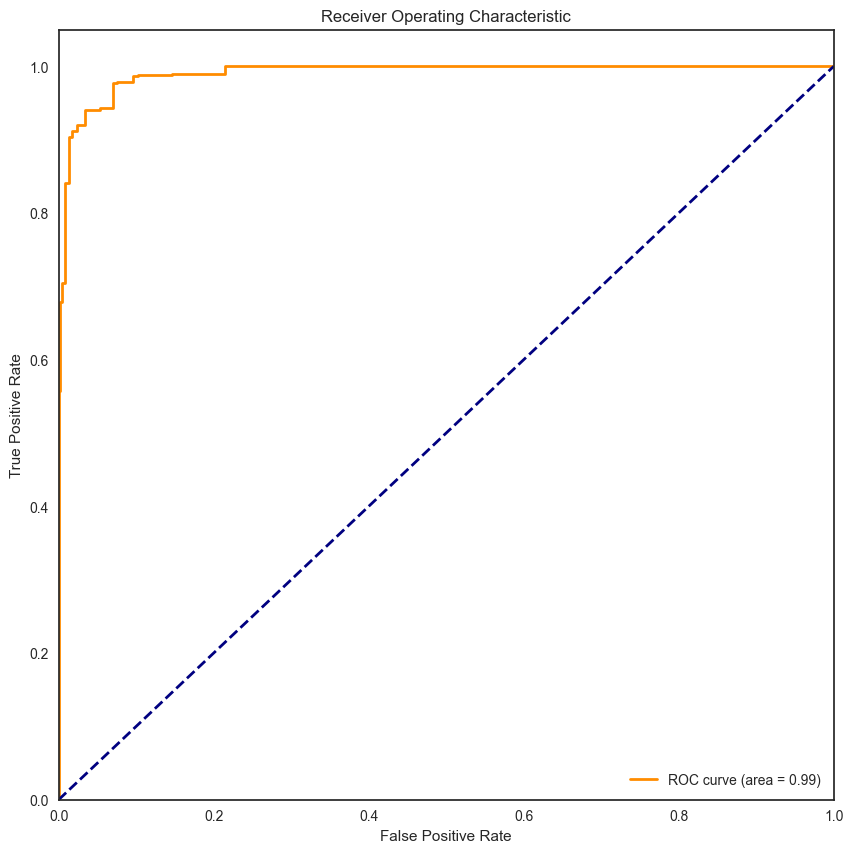

Train Error:  0.11675639457357517 Model Name:  Random Forest
Best Model:  Random Forest Best Error:  0.11675639457357517


In [2639]:
rf_val_preds = rf.predict(X_val)



trainError = mean_absolute_error(y_train,rf_train_preds)
testError = mean_absolute_error(y_val,rf_val_preds)
print(trainError, testError)
evaluate_model(y_test, rf_test_preds)
plot_roc_curve(y_test, rf_test_preds)
bestError(testError,"Random Forest")

In [2640]:
getBestModel()

('Random Forest', 0.11675639457357517)

In [2641]:
#Save the model
import pickle
filename = 'finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))



0.11675639457357517
MAE: 0.12
MSE: 0.04
RMSE: 0.21
R2: 0.83


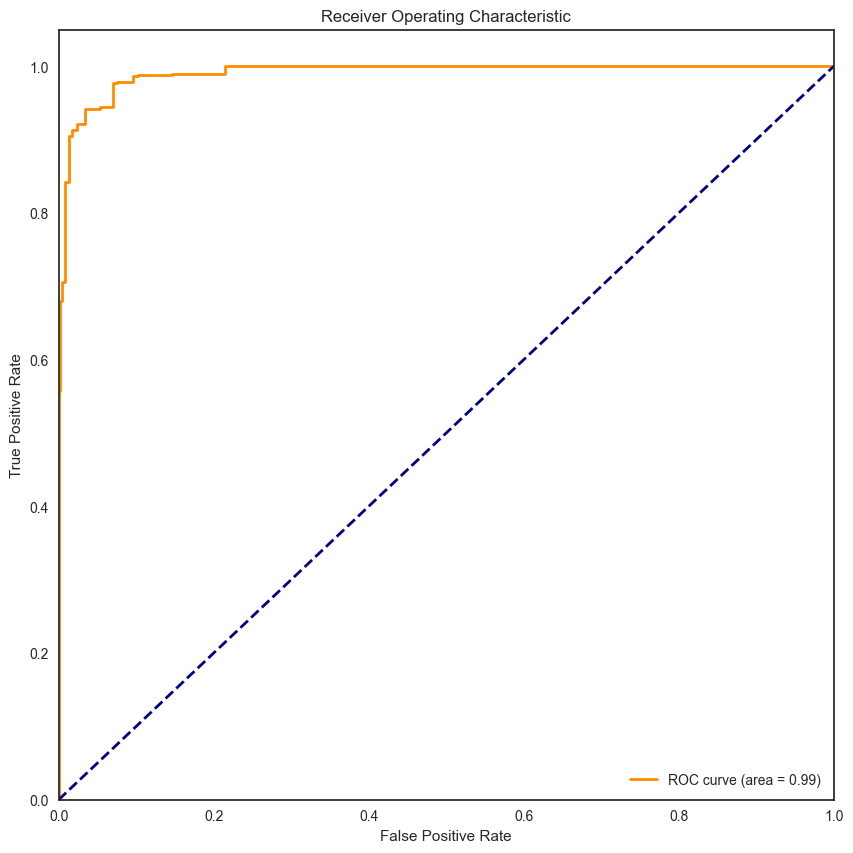

In [2642]:
#Load the model
loaded_model = pickle.load(open(filename, 'rb'))


#predict
result = loaded_model.predict(X_val)
error = mean_absolute_error(y_val,result)
print(error)

#Accuracy
evaluate_model(y_val, result)
plot_roc_curve(y_val, result)



In [2650]:
#predict on the model using the holdout set
result = loaded_model.predict(X_hold)
error = mean_absolute_error(y_hold,result)
print(error)


#Print the prediction and the actual value
for i in range(len(result)):
    print("Predicted: ",result[i], "Actual: ", y_hold[i])




#Predict if someone has heart disease

0.3798144904216446
Predicted:  0.6201855095783554 Actual:  1.0


In [2657]:
#Create a 10 new patient with the same columns as the dataset
#['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall']

new_patient = np.array([[63,1,3,145,233,1,0,150,0,2.3,0,0,1],
                        [37,1,2,130,250,0,1,187,0,3.5,0,0,2],
                        [41,0,1,130,204,0,0,172,0,1.4,2,0,2],
                        [56,1,1,120,236,0,1,178,0,0.8,2,0,2],
                        [57,0,0,120,354,0,1,163,1,0.6,2,0,2],
                        [57,1,0,140,192,0,1,148,0,0.4,1,0,1],
                        [56,0,1,140,294,0,0,153,0,1.3,1,0,2],
                        [44,1,1,120,263,0,1,173,0,0,2,0,3],
                        [52,1,2,172,199,1,1,162,0,0.5,2,0,3],
                        [57,1,2,150,168,0,1,174,0,1.6,2,0,2]])







#Predict if the patient has heart disease or not
#For each patient in the new_patient array
for patient in new_patient:
    #Reshape the data as a sample containing a single instance with 13 features
    patient = patient.reshape(1, -1)
    #Predict if the patient has heart disease
    result = loaded_model.predict(patient)
    print("Does the patient have heart disease? ")
    print(result)

    #Level of tolerance for the percentage of error
    tolerance = 0.3
    #If the prediction is less than 0.3 away from 1, then the patient has heart disease
    if result > 1 - tolerance:
        print("Yes")
    else:
        print("No")









Does the patient have heart disease? 
[0.91666854]
Yes
Does the patient have heart disease? 
[0.86901487]
Yes
Does the patient have heart disease? 
[0.99274554]
Yes
Does the patient have heart disease? 
[0.93699554]
Yes
Does the patient have heart disease? 
[0.62727181]
No
Does the patient have heart disease? 
[0.92534155]
Yes
Does the patient have heart disease? 
[0.98211969]
Yes
Does the patient have heart disease? 
[0.87723226]
Yes
Does the patient have heart disease? 
[0.93429022]
Yes
Does the patient have heart disease? 
[0.94418858]
Yes
